# Bayesian optimization of a time-consuming simulator

O. Roustant, INSA Toulouse

The aim of the lab is to optimize a time-consuming simulator using the Efficient Global Optimization (EGO) method. As a toy example, the simulator chosen here mimics a catapult. There are 4 input variables, tuning the catapult, and 1 output, giving the distance of the projectile mark to the catapult. We want to find the value(s) of the input variable(s) maximizing that distance. Notice that the simulator is not time-consuming. However, for the sake of realism, we will limit the computational budget to 36 runs.

## "By-hand" Optimization
<br> We provide here a shiny application created by Nicolas Durrande, which allows using the simulator interactively. Alternatively, you can use the web application, available here : https://durrande.shinyapps.io/catapult/

In [3]:
library(shiny)
# runApp()

*Question: By playing with the simulator, propose a set of input values giving the largest possible value of the output. Here we consider the noise-free case, by fixing the wind to zero.*

To continue running the notebook, you may need to interrupt the kernel (square symbol!). Then load the two following scripts, containing useful functions. 

In [4]:
source("catapultSettings.R")
source("catapultFunctions.R")

## Design of experiments
Let us create an initial design of experiments and compute the corresponding values.

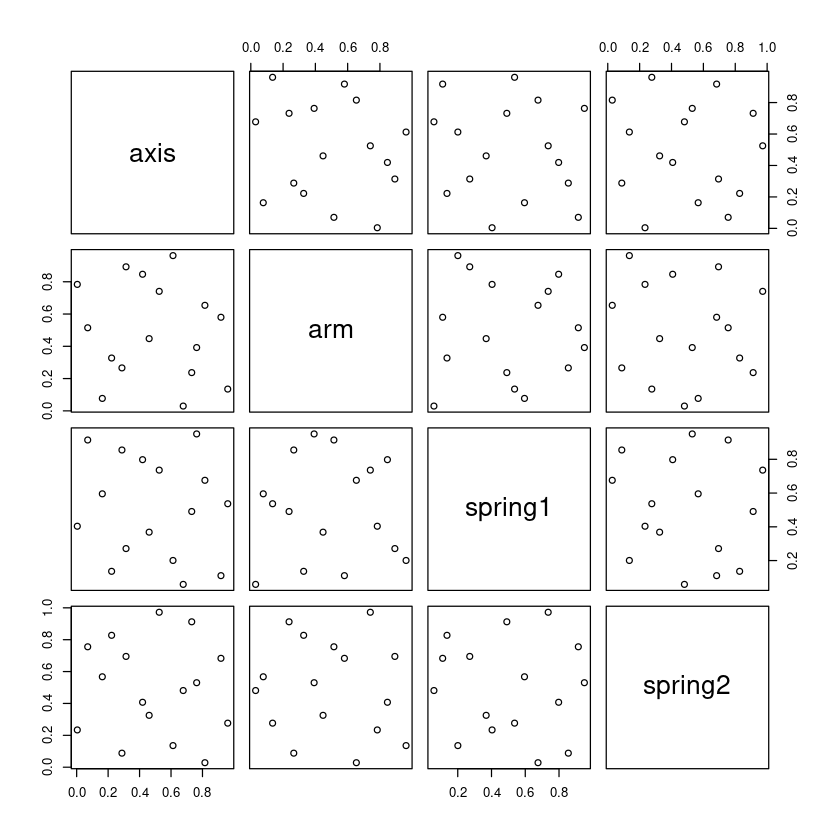

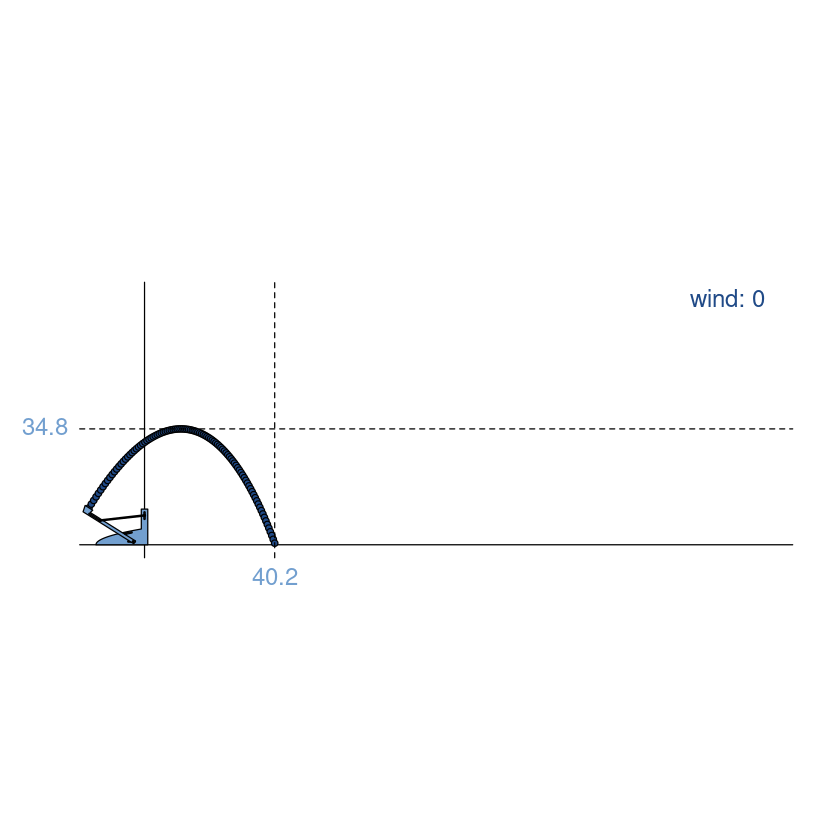

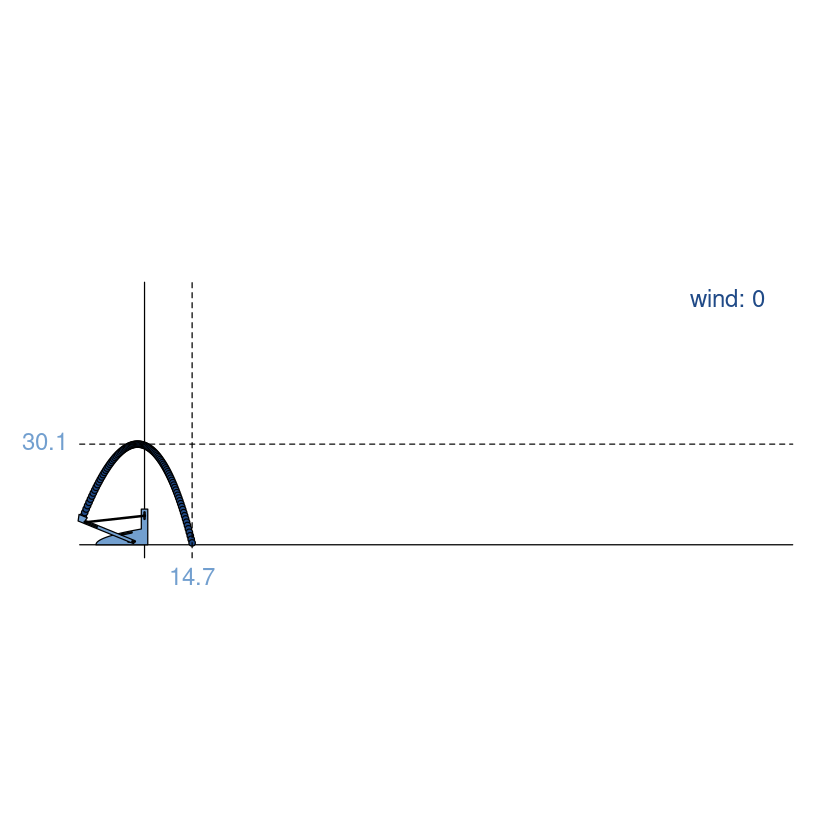

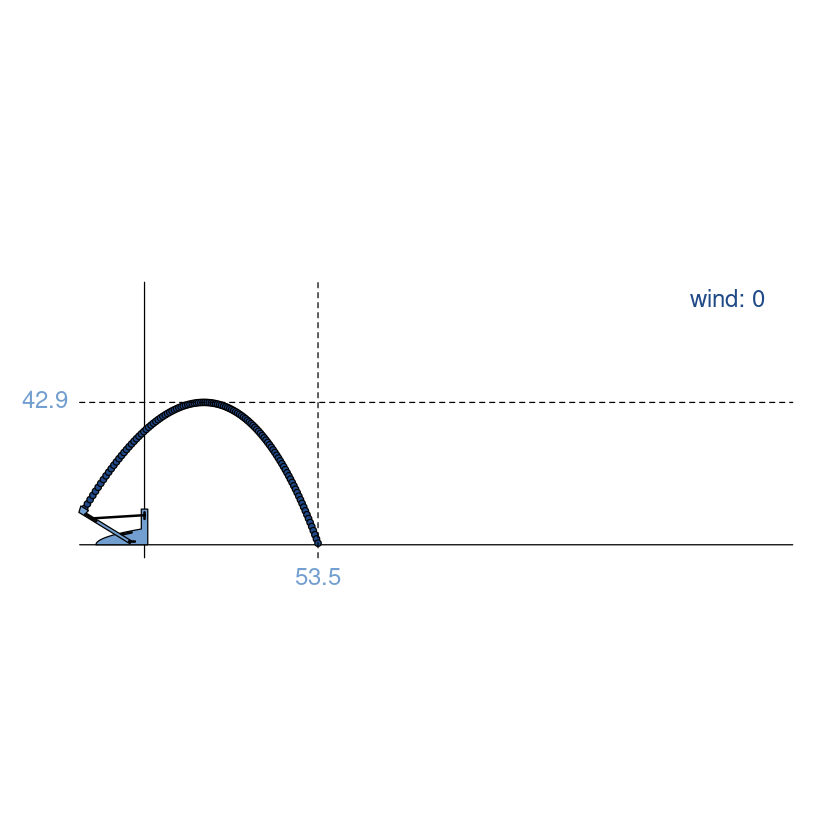

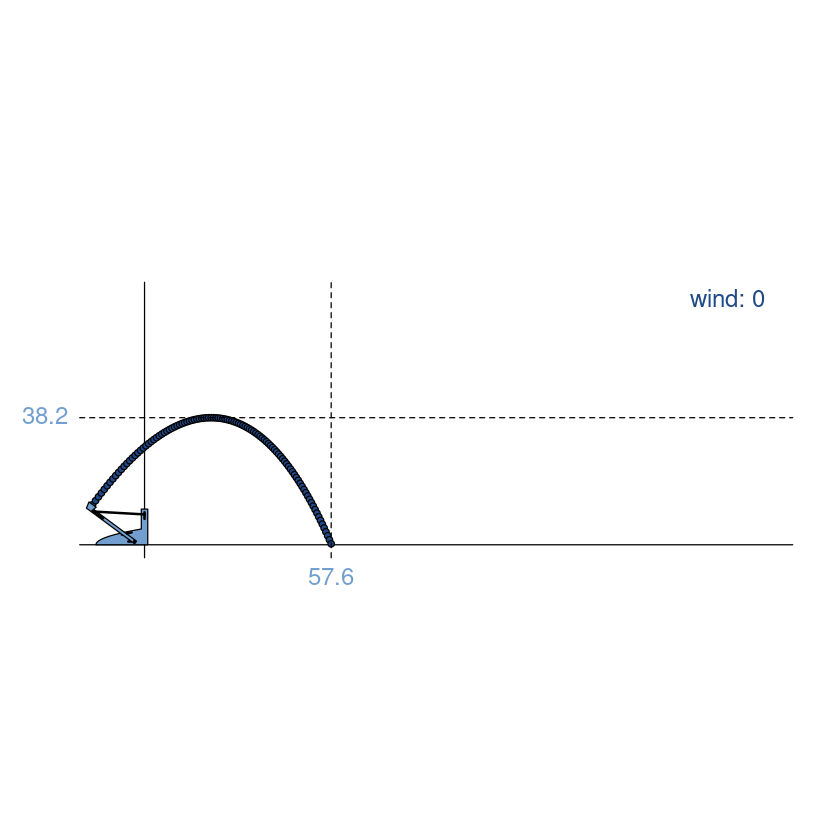

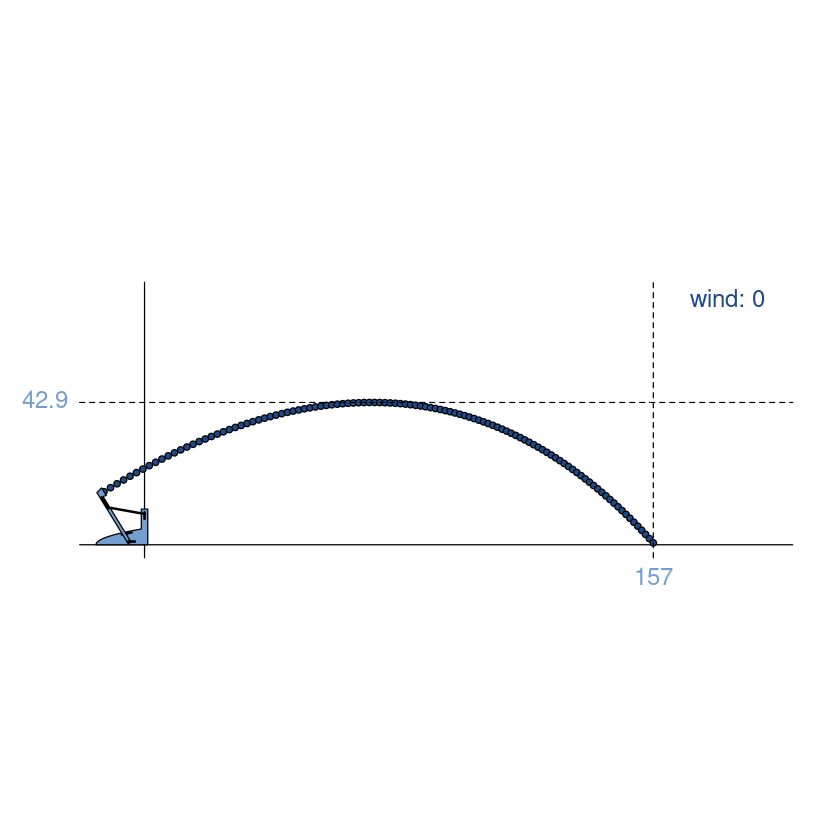

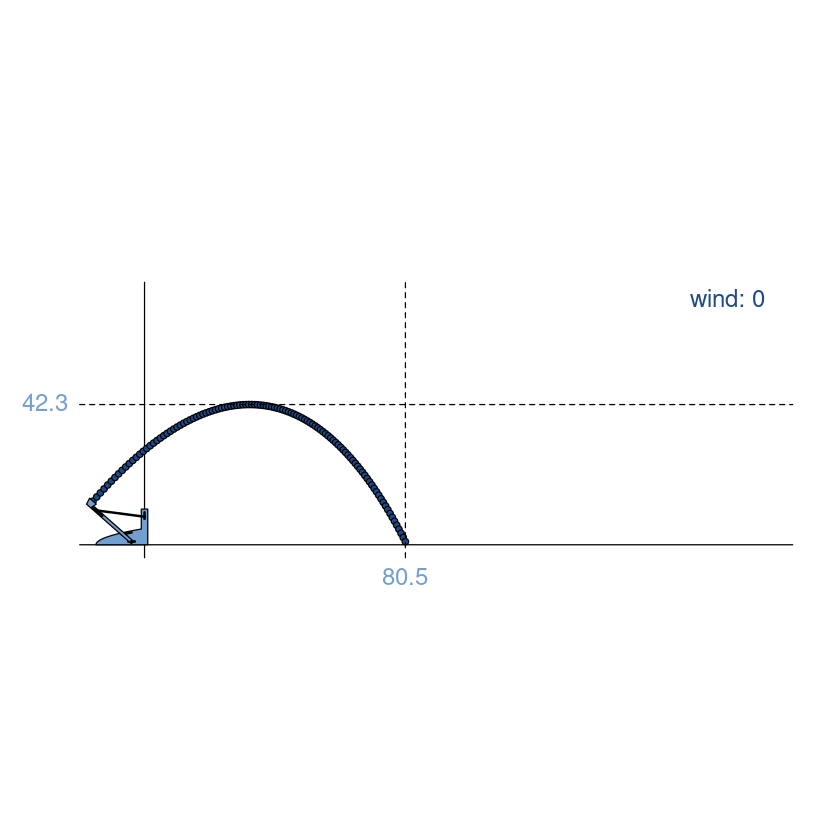

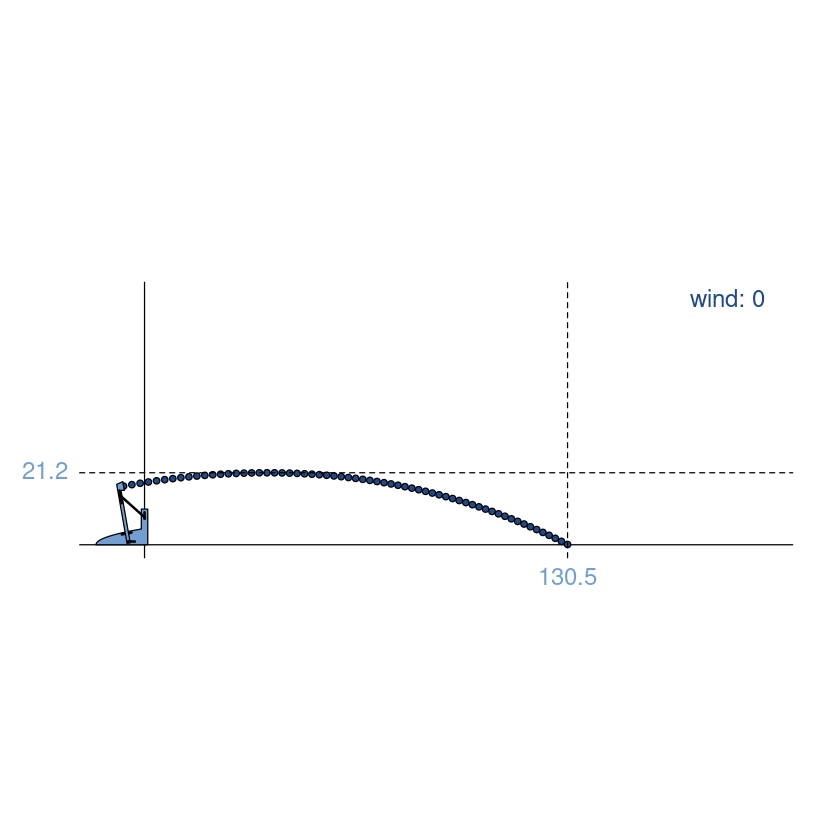

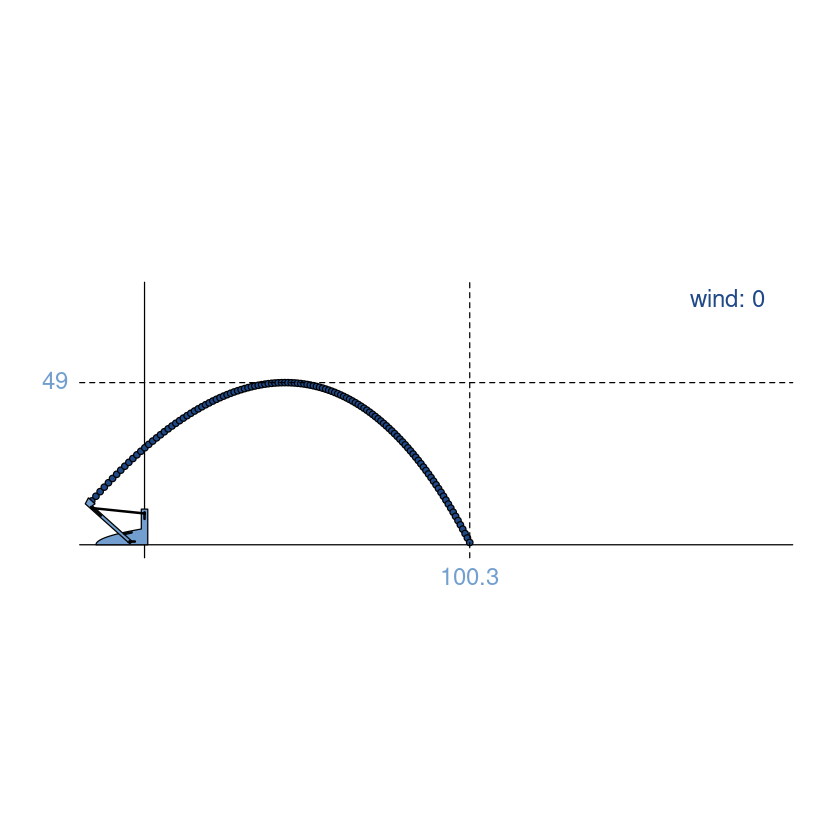

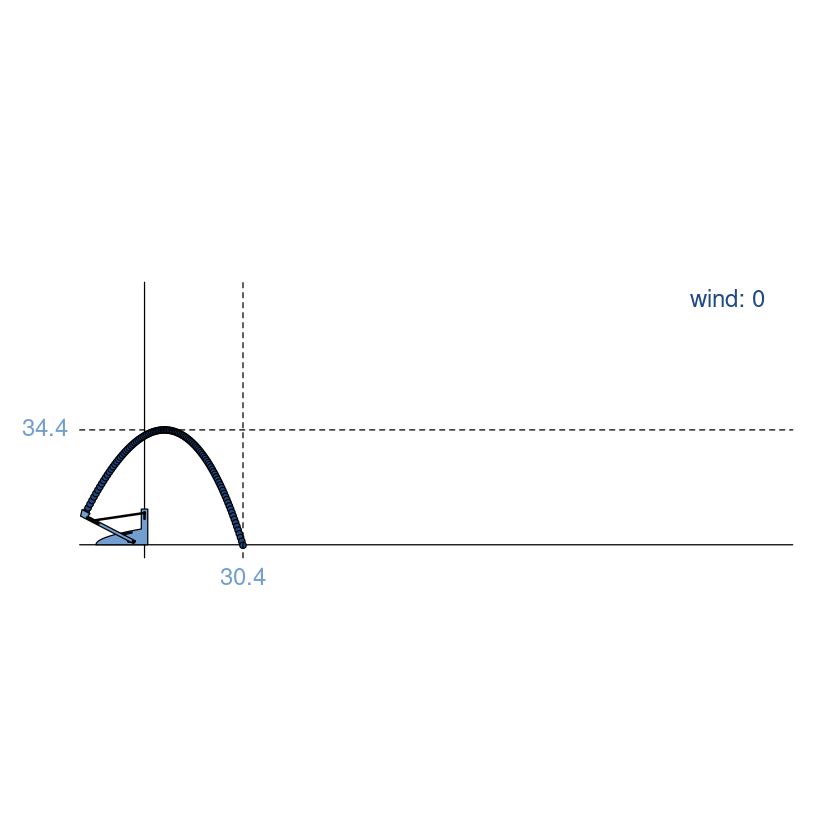

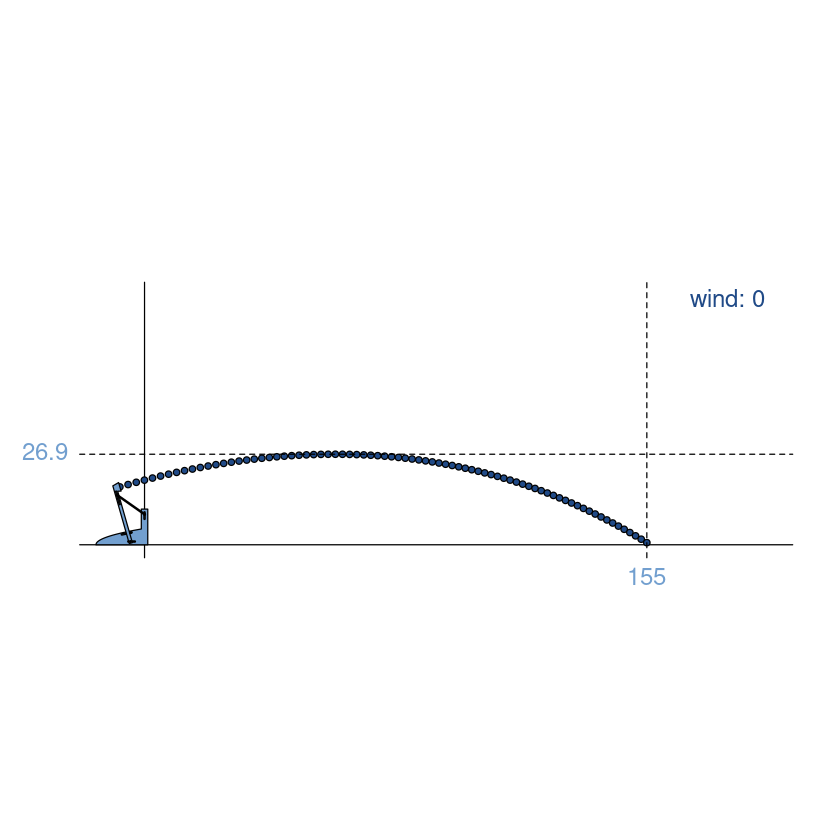

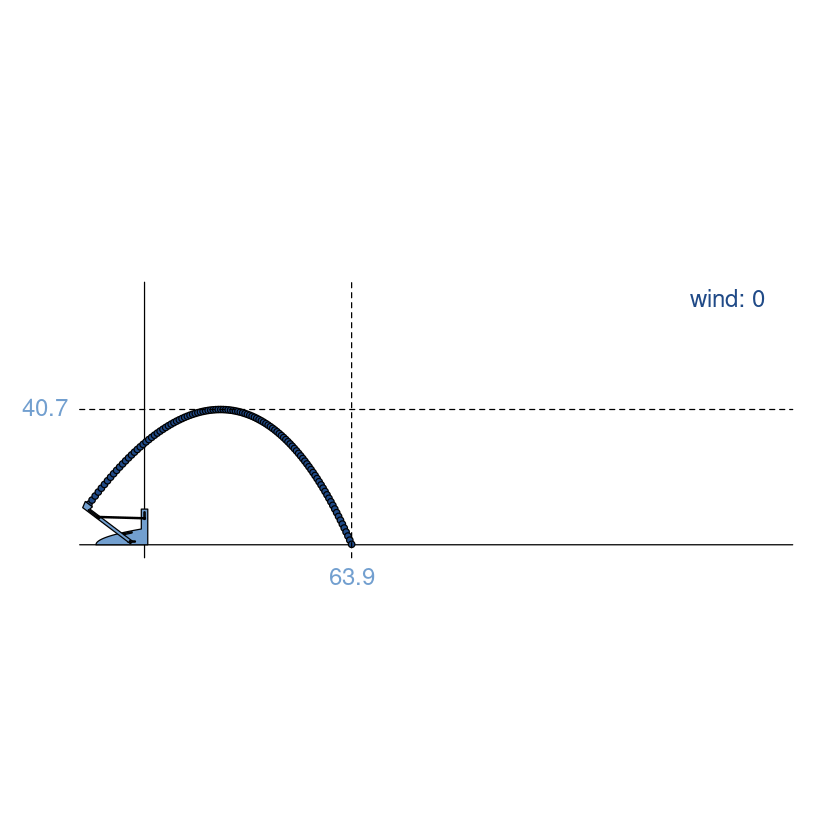

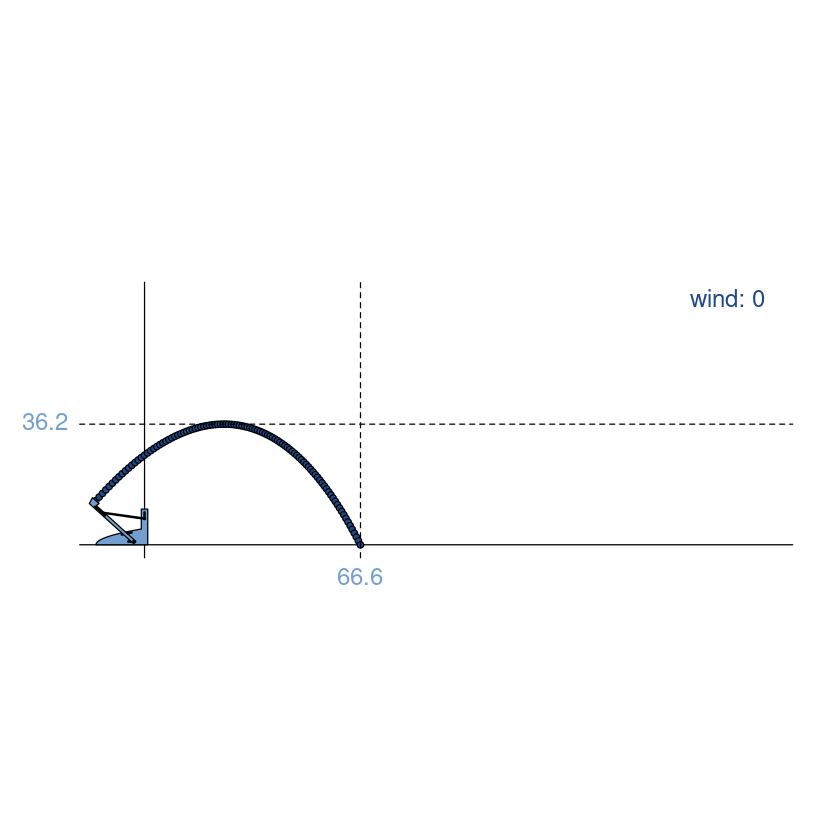

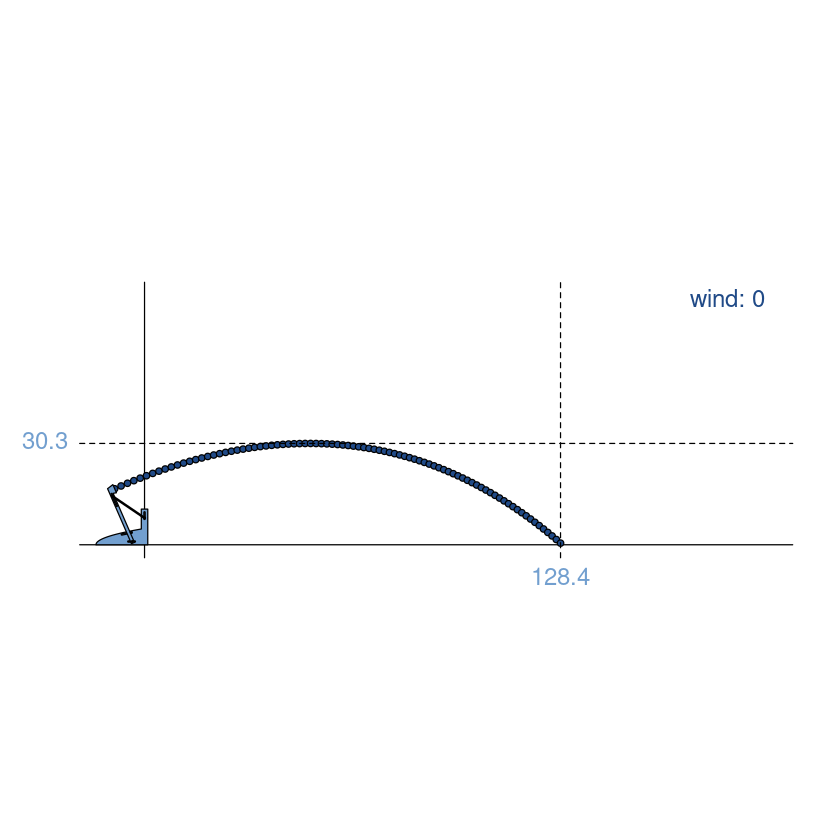

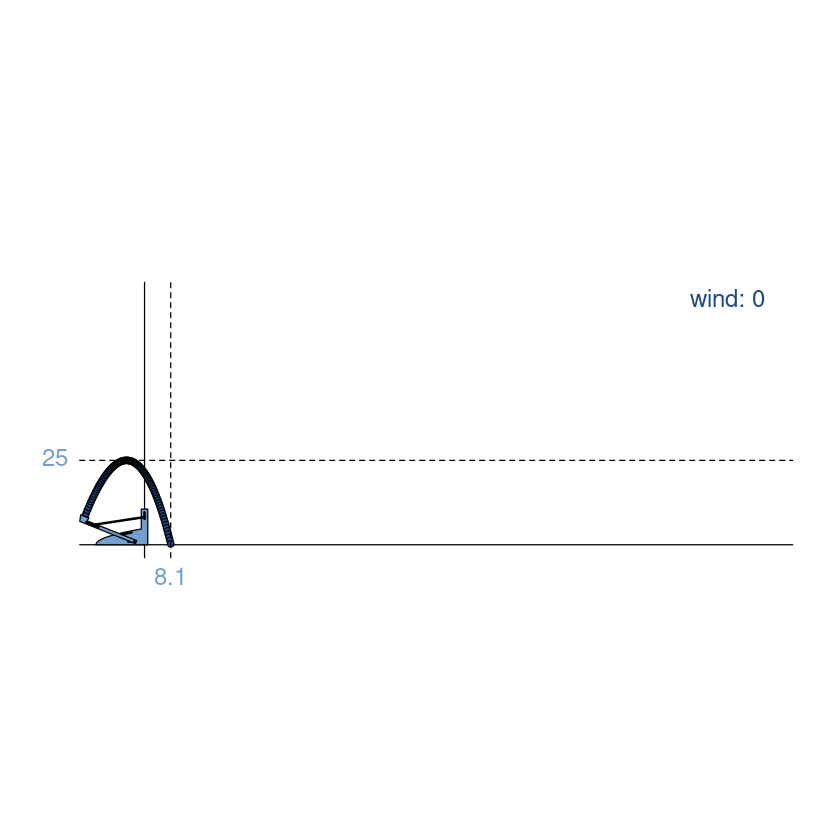

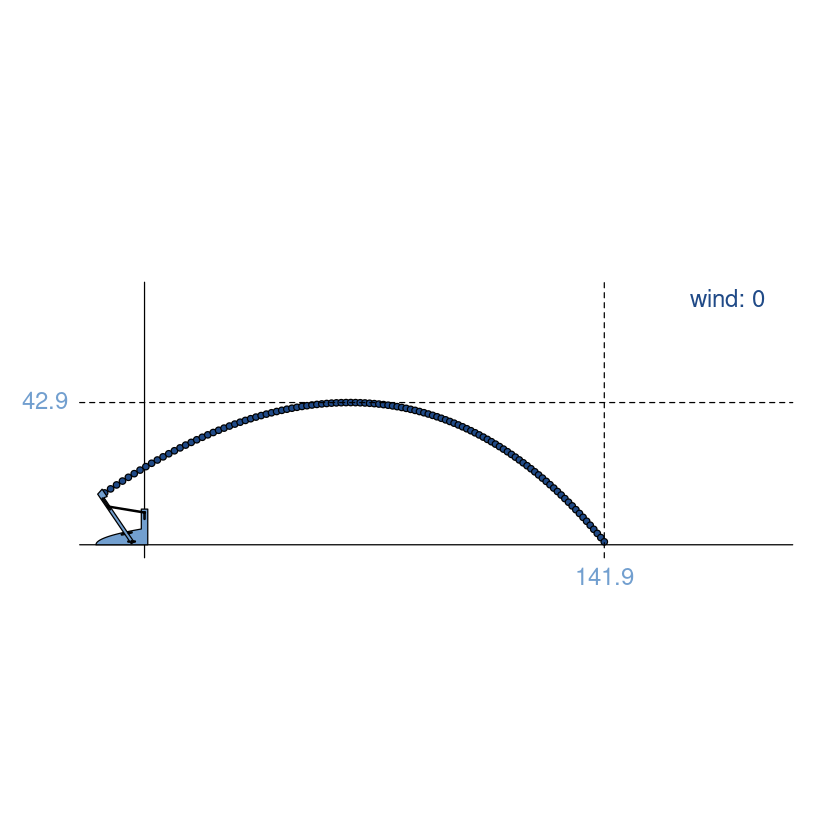

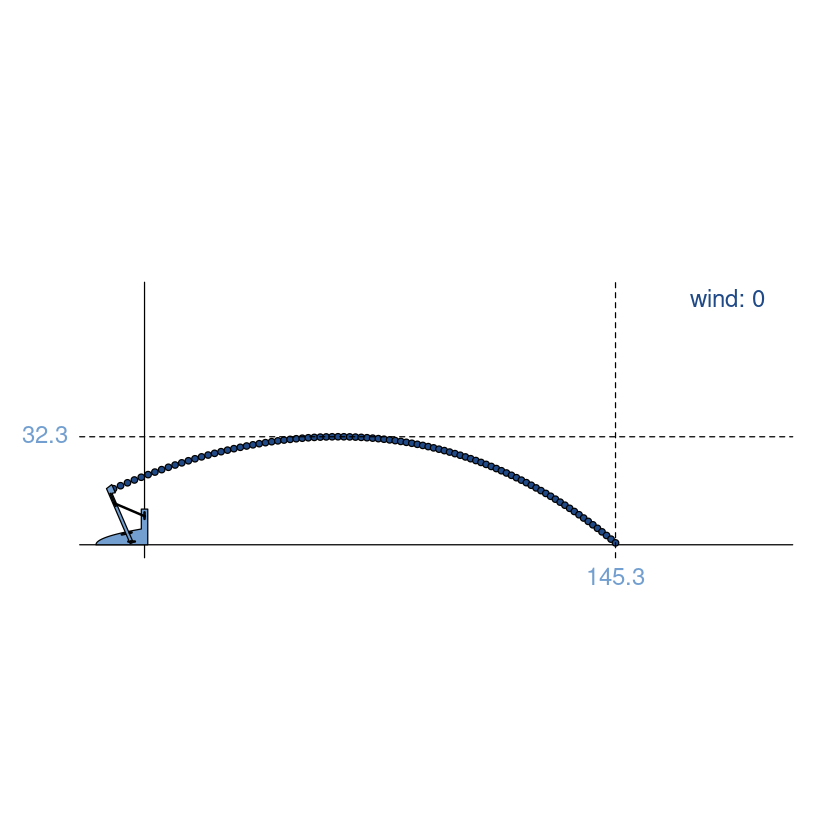

In [6]:
library(DiceDesign)
set.seed(0)
ninit <- 16
d <- 4
X0 <- lhsDesign(n = ninit, dimension = d)$design
Xopt <- maximinESE_LHS(X0, it = 10)
## you may be interested in the convergence
#plot(Xopt$critValues,type="l")
X <- Xopt$design
colnames(X) <- c("axis", "arm", "spring1", "spring2")
pairs(X)
## compute the output values
Y <- apply(X, 1, runExperiment, windFactor = 0)[1, ]


Question : Observe that the design of experiments is "space-filling". <br> Why did we chose that kind of designs? What is the current maximum? Is it far from the maximum value found by-hand?

In [7]:
max(Y)

[1] 156.99

## Descriptive statistics
*Question : Can you see a simple input-output relation? What can you say about the area corresponding to the maximum value?*

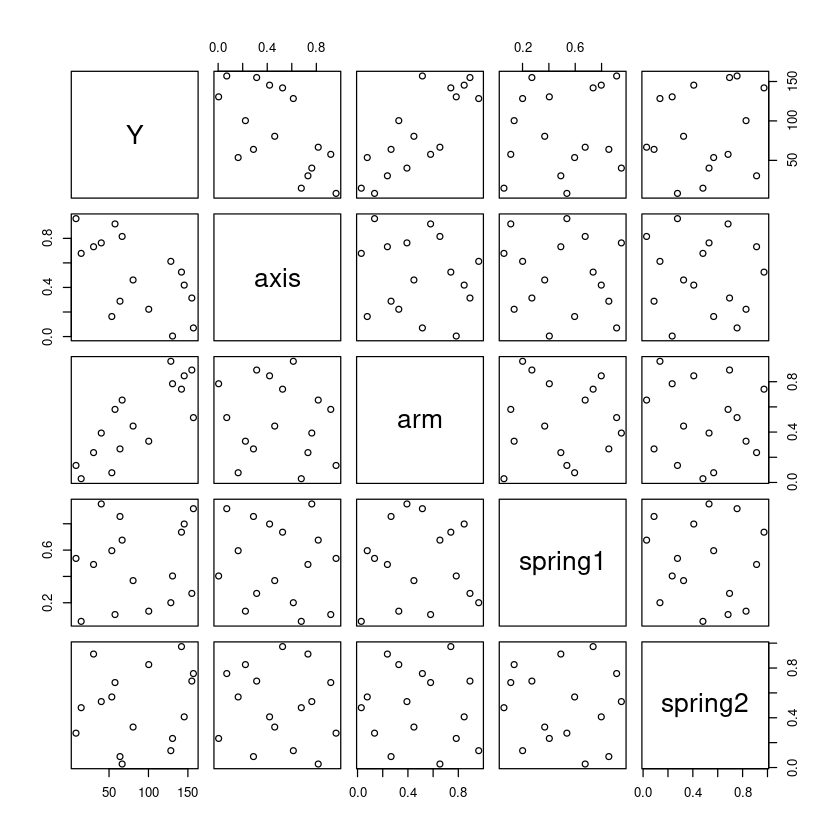

In [8]:
pairs(cbind(Y, X))

## Regression metamodel
<br> *Question : Try the linear models below. If you replace the simulator by one of this model, what would be the optimum? Is it far from your previous guess?*


Call:
lm(formula = Y ~ ., data = myData)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.660  -7.653   2.556   7.149  20.136 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    39.51      14.64   2.699   0.0207 *  
axis          -80.85      12.33  -6.555 4.11e-05 ***
arm           129.26      12.23  10.569 4.24e-07 ***
spring1        11.87      12.28   0.967   0.3543    
spring2        33.90      12.32   2.751   0.0188 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.96 on 11 degrees of freedom
Multiple R-squared:  0.9458,	Adjusted R-squared:  0.926 
F-statistic: 47.94 on 4 and 11 DF,  p-value: 6.787e-07


[1] 86.3381


Call:
lm(formula = Y ~ . + I(axis^2) + I(arm^2) + I(spring1^2) + I(spring2^2), 
    data = myData)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.762  -5.214   1.222   5.677  19.429 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     53.83      32.79   1.642    0.145
axis           -66.94      59.98  -1.116    0.301
arm            100.15      69.08   1.450    0.190
spring1        -33.59      68.22  -0.492    0.637
spring2         11.61      65.38   0.178    0.864
I(axis^2)      -15.33      59.87  -0.256    0.805
I(arm^2)        28.48      68.92   0.413    0.692
I(spring1^2)    46.65      65.97   0.707    0.502
I(spring2^2)    21.61      64.00   0.338    0.745

Residual standard error: 16.53 on 7 degrees of freedom
Multiple R-squared:  0.9516,	Adjusted R-squared:  0.8964 
F-statistic: 17.22 on 8 and 7 DF,  p-value: 0.0005949


Start:  AIC=92.23
Y ~ axis + arm + spring1 + spring2

          Df Sum of Sq     RSS     AIC
- spring1  1     182.3  2326.8  90.765
<none>                  2144.5  92.232
- spring2  1    1475.9  3620.4  97.839
- axis     1    8376.9 10521.5 114.908
- arm      1   21779.5 23924.1 128.051

Step:  AIC=90.77
Y ~ axis + arm + spring2

          Df Sum of Sq     RSS     AIC
<none>                  2326.8  90.765
- spring2  1    1392.5  3719.3  95.497
- axis     1    8978.6 11305.4 113.285
- arm      1   21672.6 23999.4 125.329



Call:
lm(formula = Y ~ axis + arm + spring2, data = myData)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.969  -9.245   2.647   5.528  24.492 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    47.19      12.27   3.846  0.00233 ** 
axis          -82.69      12.15  -6.805 1.89e-05 ***
arm           128.87      12.19  10.572 1.96e-07 ***
spring2        32.79      12.24   2.680  0.02004 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.92 on 12 degrees of freedom
Multiple R-squared:  0.9411,	Adjusted R-squared:  0.9264 
F-statistic: 63.96 on 3 and 12 DF,  p-value: 1.188e-07


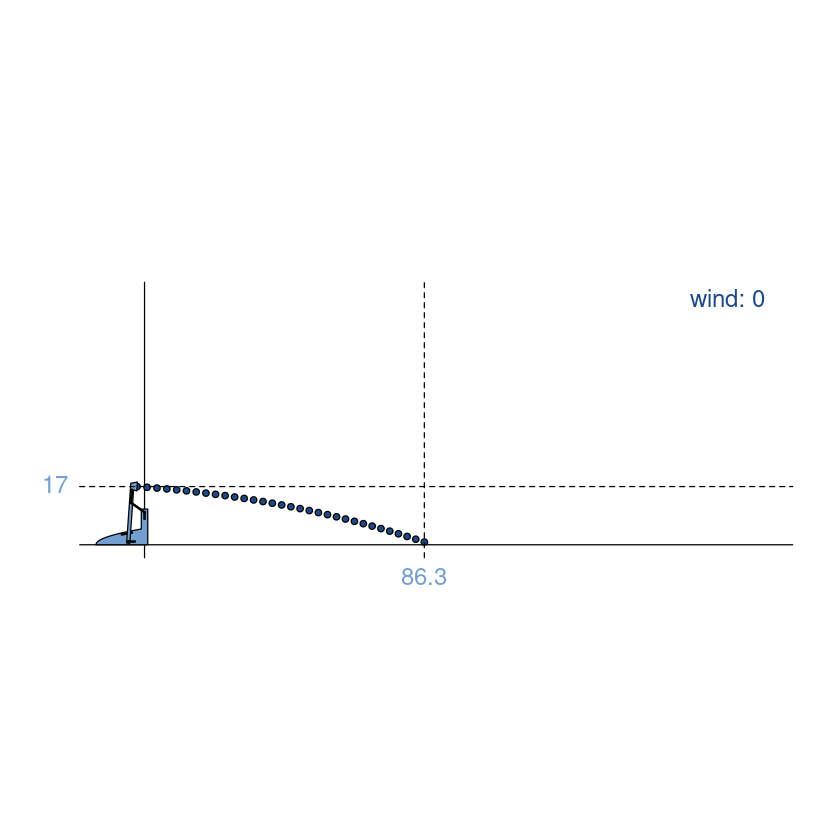

In [9]:
myData <- data.frame(X, Y = Y)
mReg <- lm(Y ~ ., data = myData)
summary(mReg)
runExperiment(c(0, 1, 1, 1), windFactor = 0)[1]
mReg2 <- lm(Y~ . + I(axis^2) + I (arm^2) + I (spring1^2) + I(spring2^2), data = myData)
summary(mReg2)
mStep <- step(object = mReg, scope = mReg2, direction = "both", k = log(length(Y)))
summary(mStep)

## Bayesian optimization
Now, let us try the EGO method (Bayesian optimization)
<br> *Question : Recall its main principles.*

In [11]:
library(DiceKriging)
mGP0 <- km(~ 1, design = X, response = Y, multistart = 5)
print(mGP0)   # display model
plot(mGP0)    # visual model validation


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -73.85768 -75.5257 -75.8769 -76.70161 -76.9652 



ERROR: Error in f(model, envir = envir.logLik): Package "foreach" not found


*Questions: What is the role of the argument 'multistart'? What can you say about the performance and the validity of this first model?*

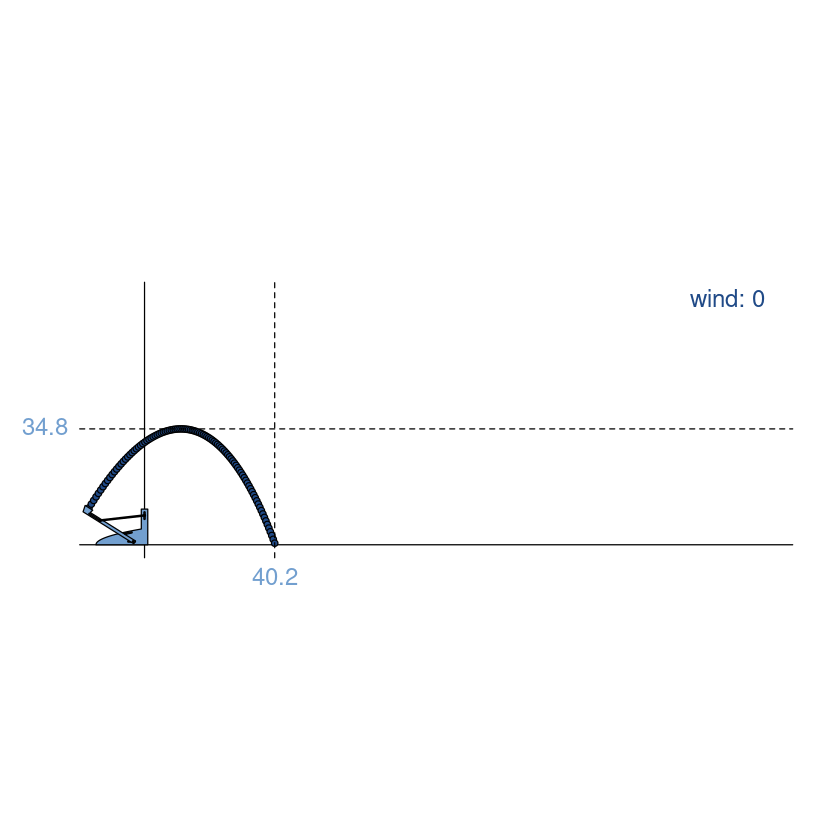

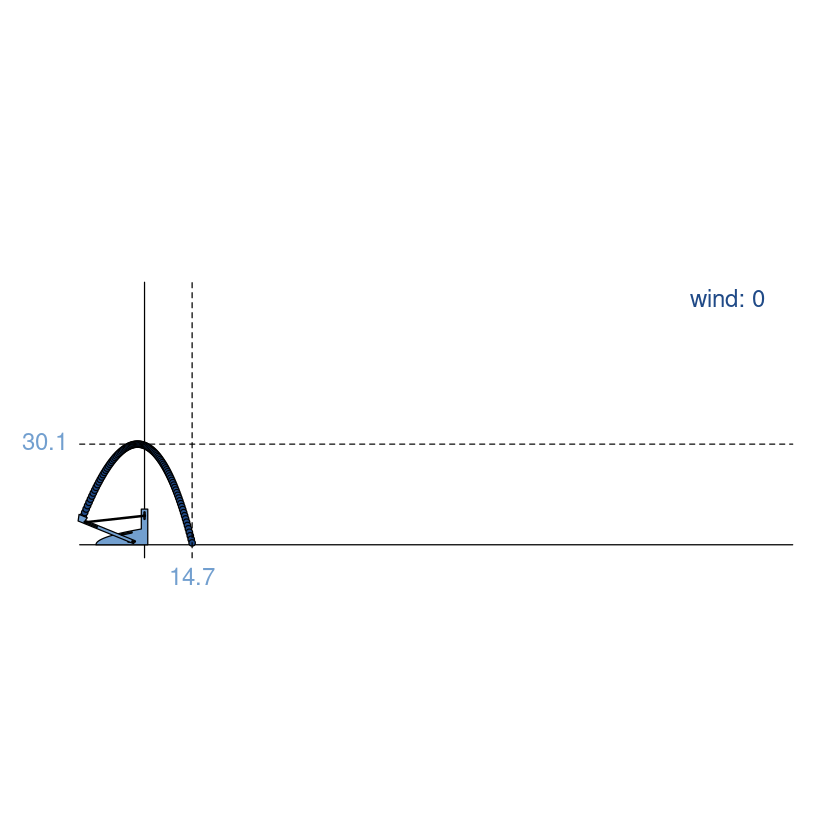

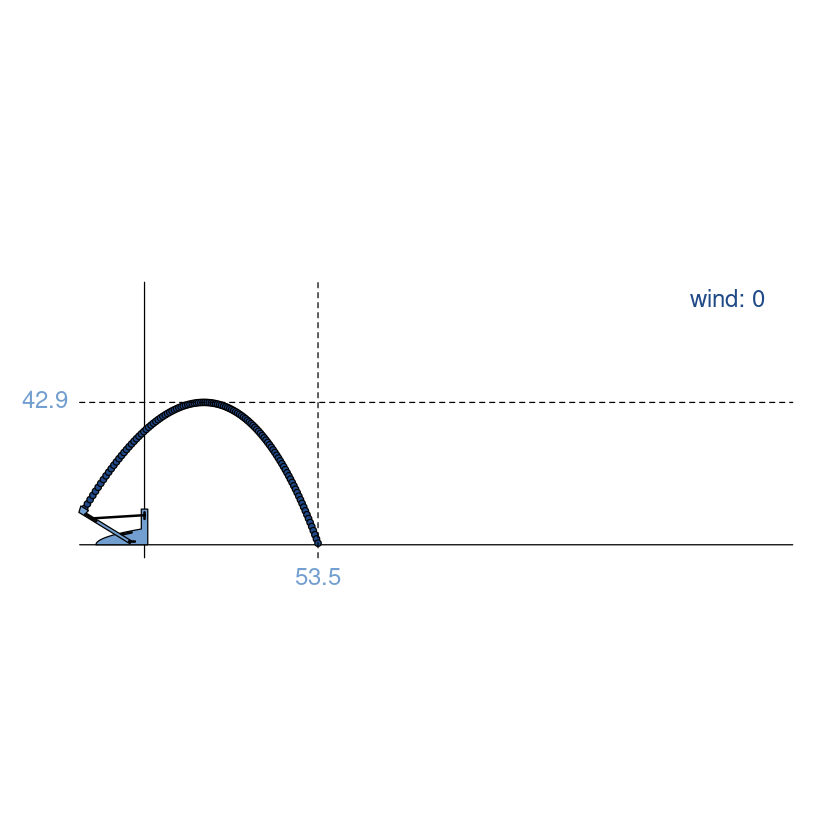

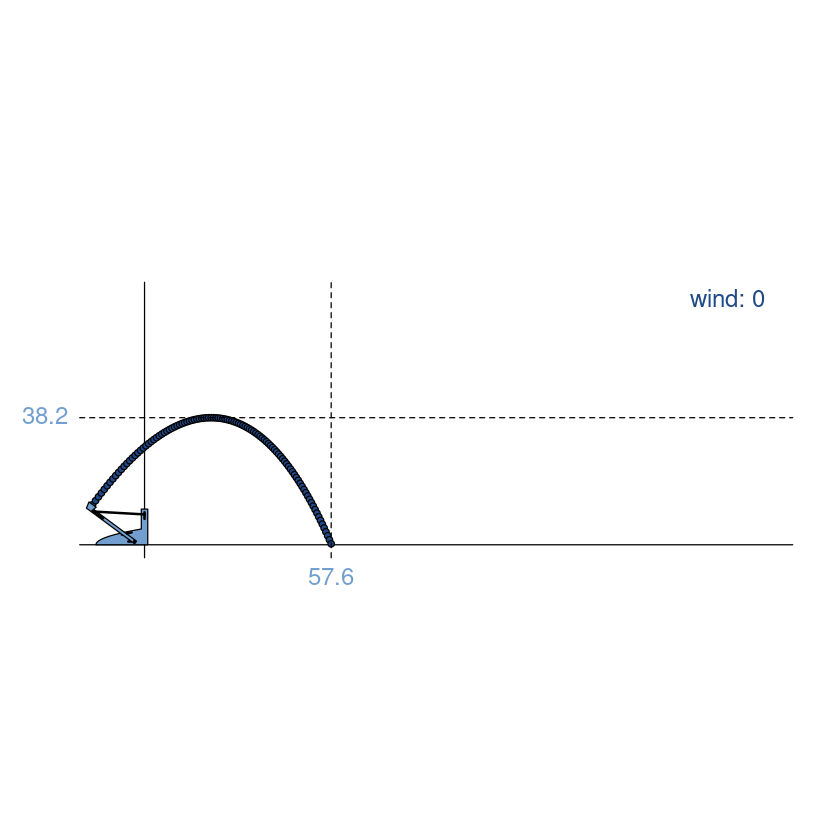

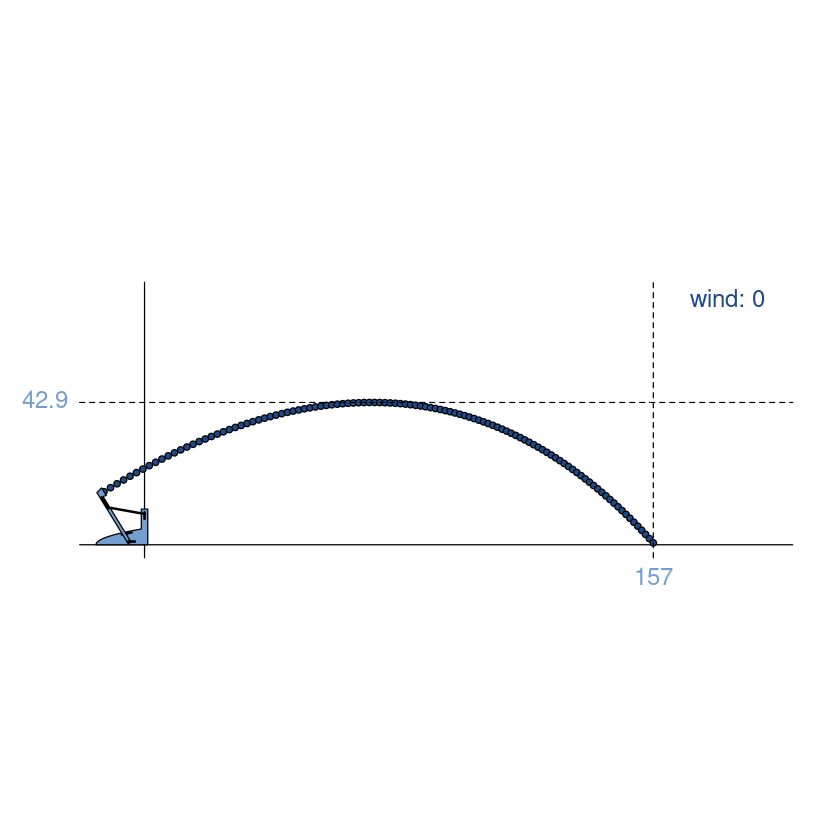

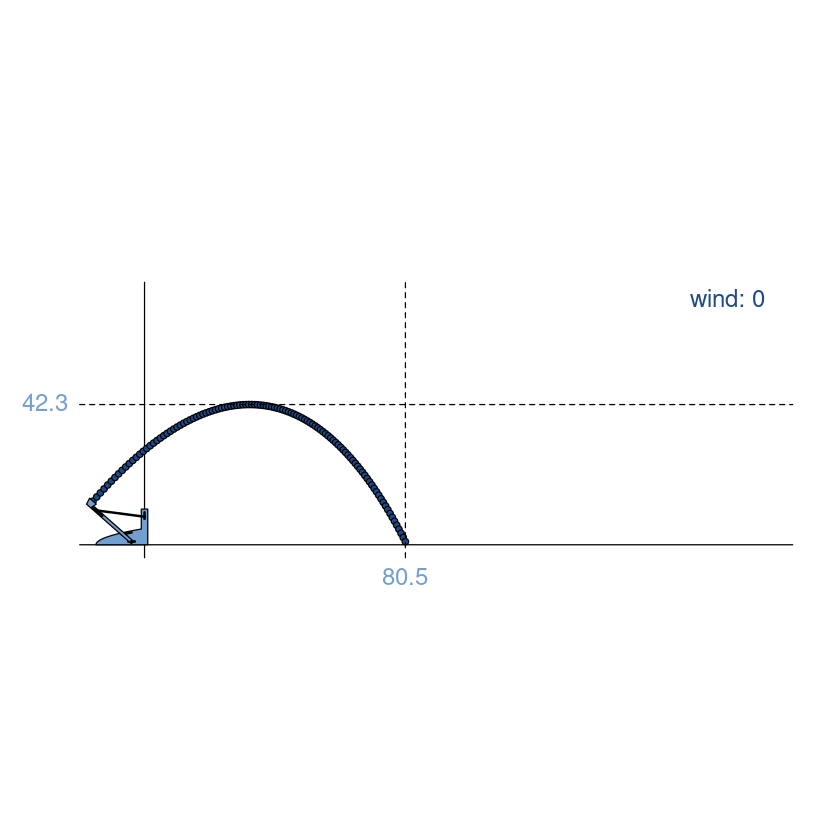

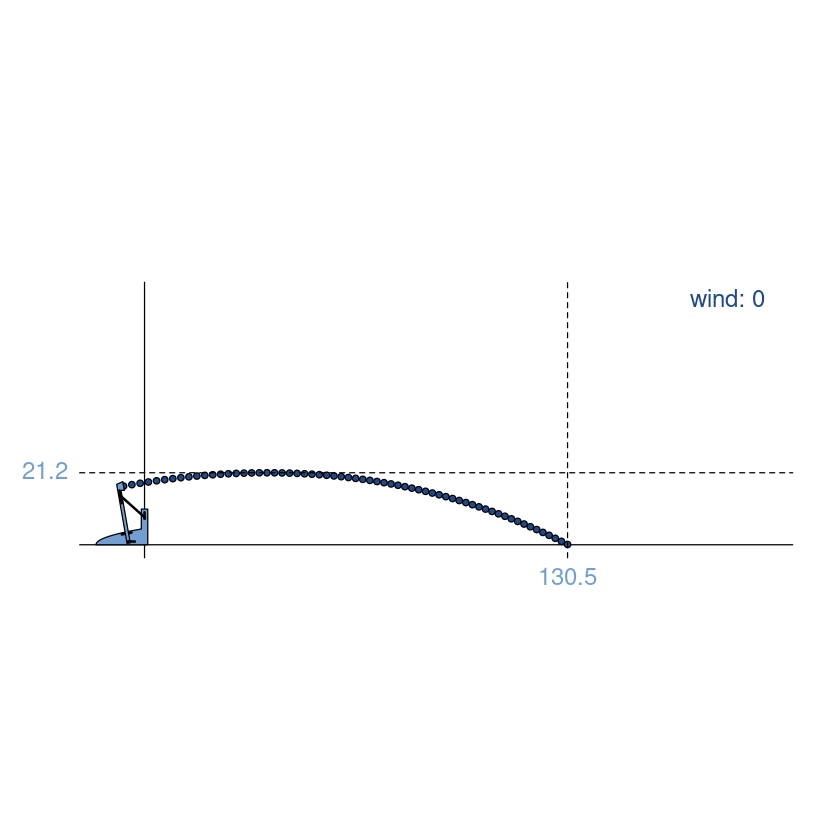

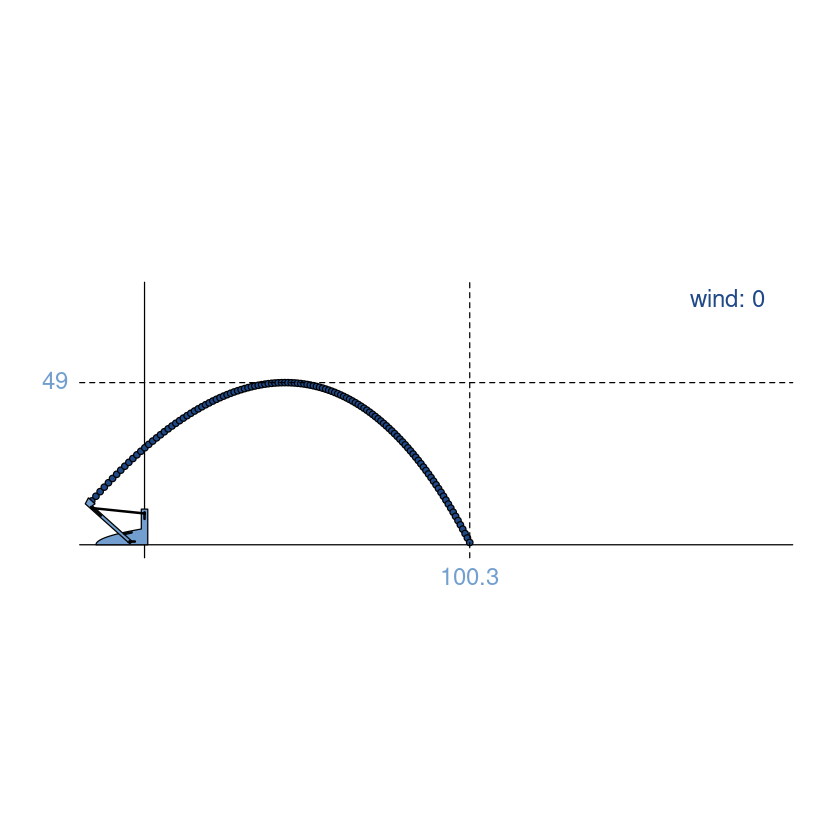

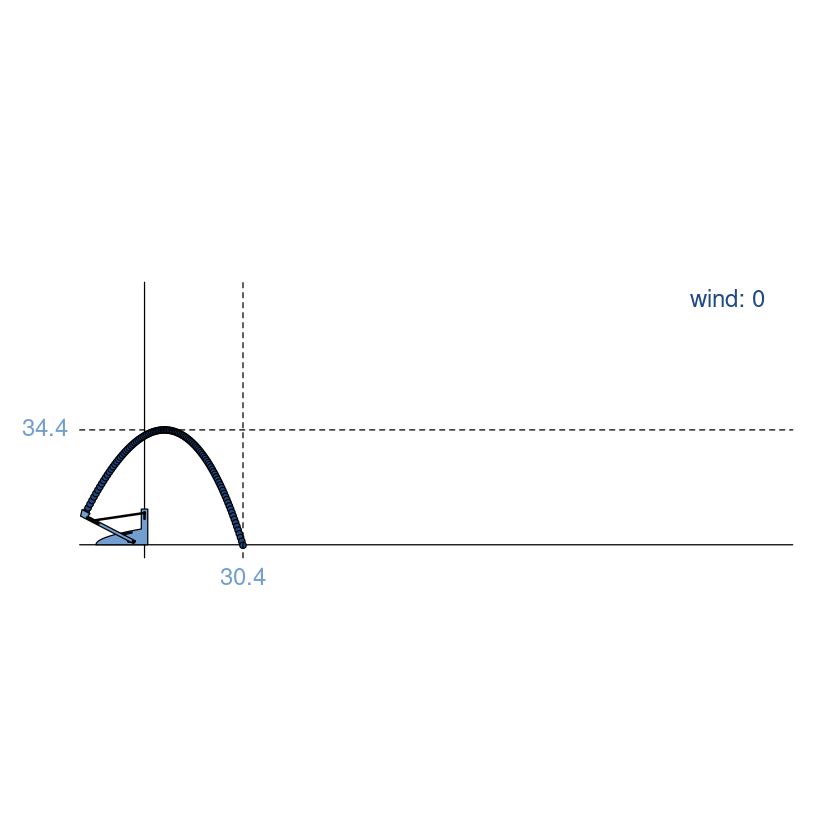

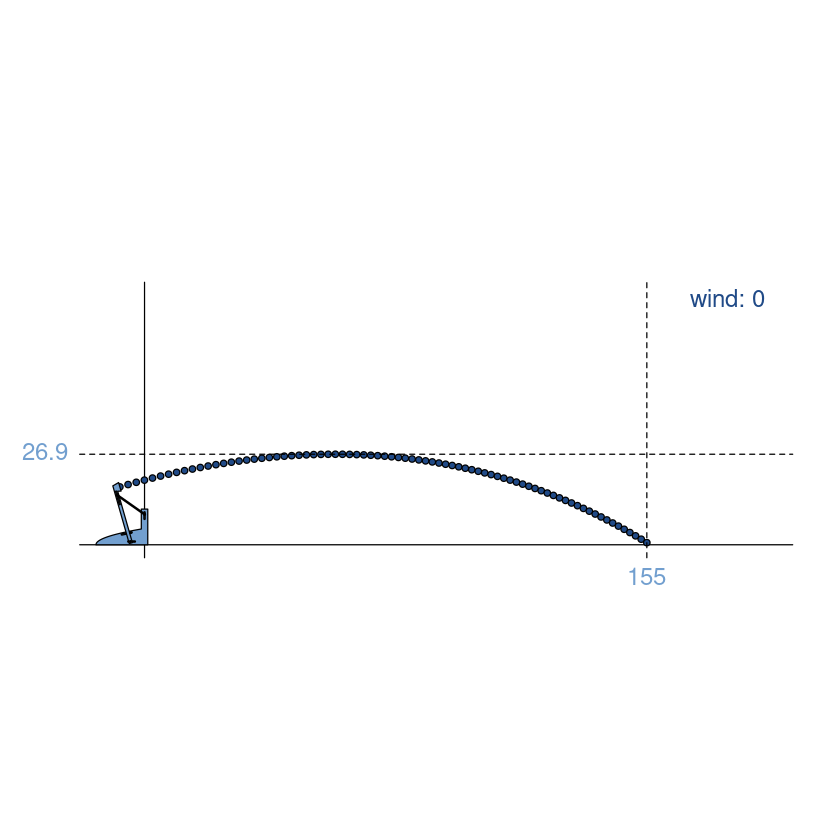

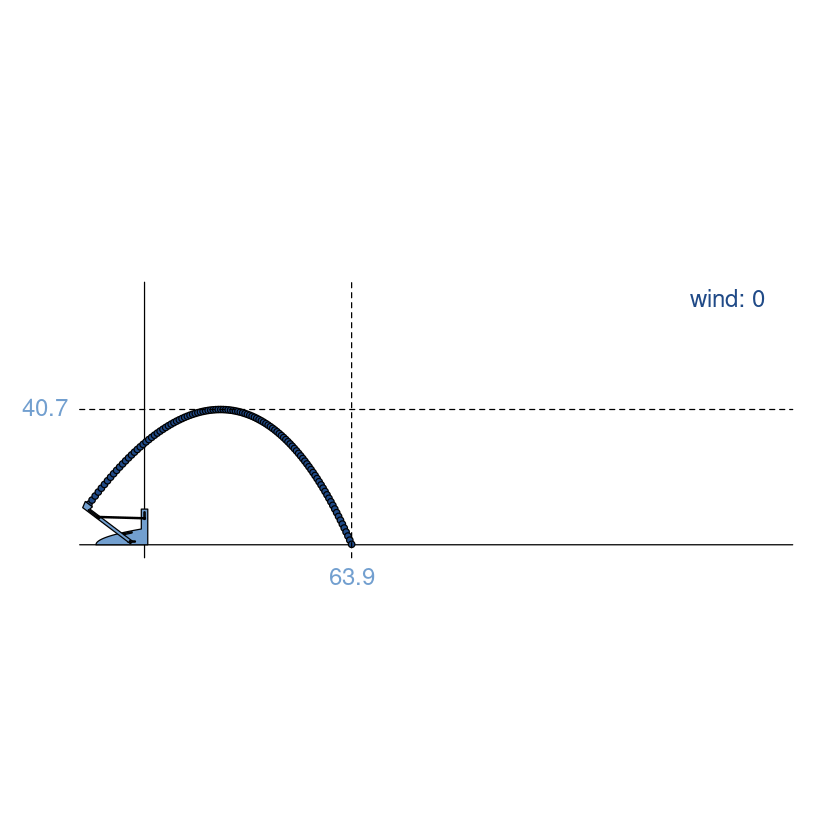

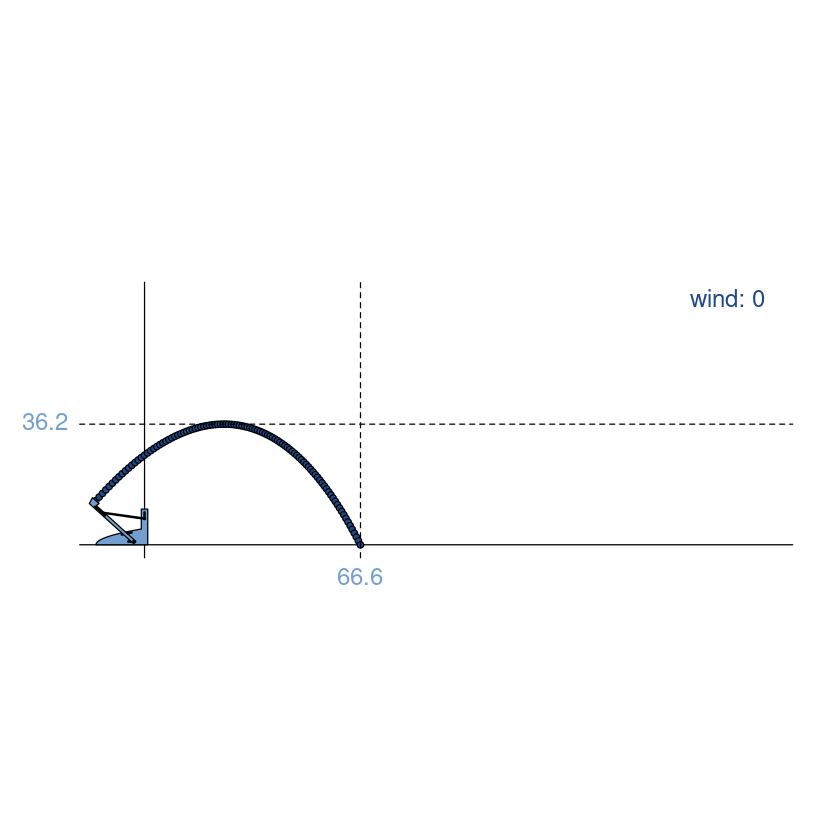

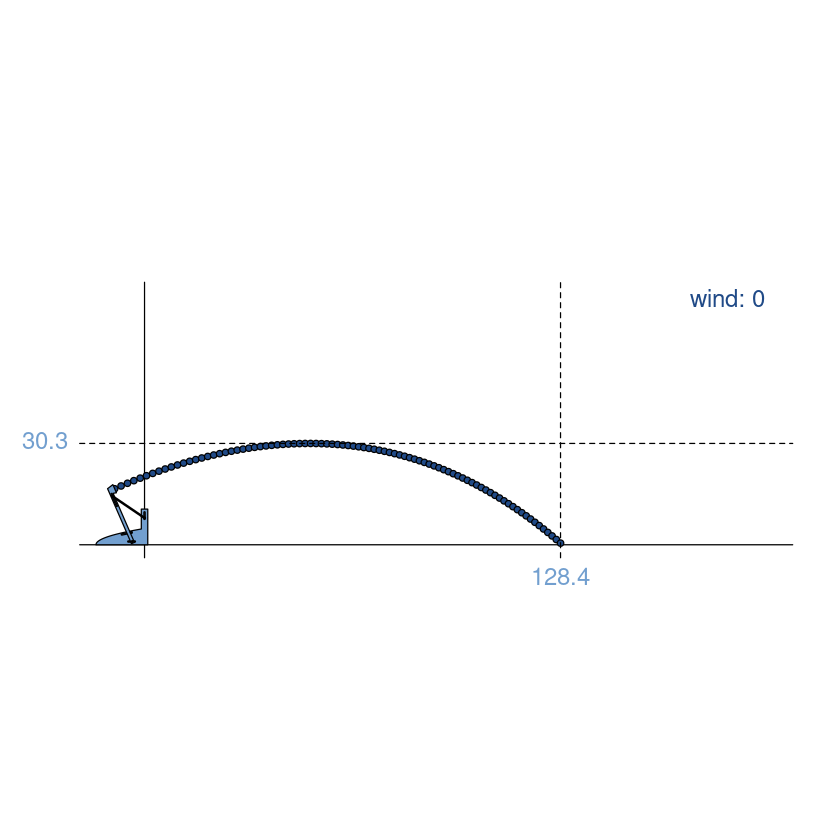

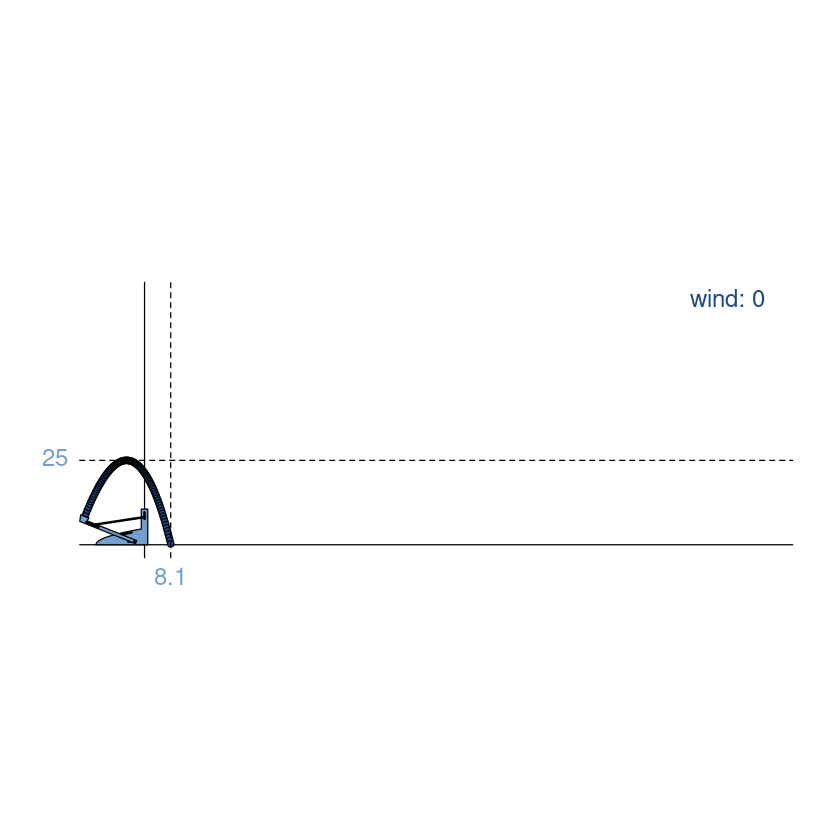

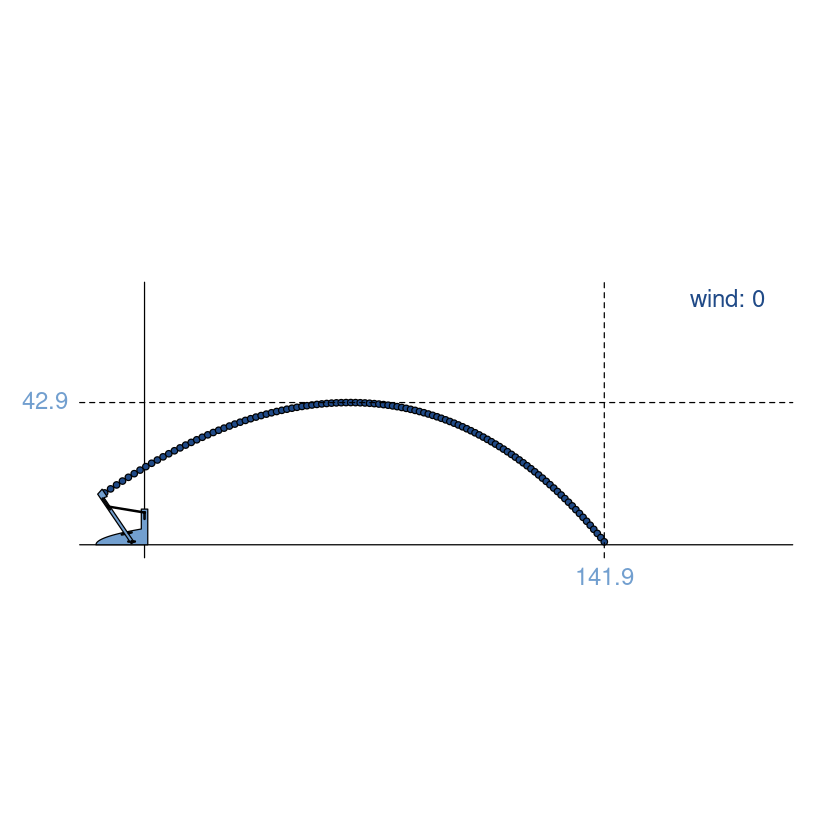


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -74.49032 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        74.49  |proj g|=       1.5052
At iterate     1  f =       72.649  |proj g|=         1.414
At iterate     2  f =       71.336  |proj g|=        1.2504
At iterate     3  f =       71.264  |proj g|=        1.2404
At iterate     4  f =       71.254  |proj g|=       0.85273
At iterate     5  f =       71.128  |proj g|=       0.45939
At iterate     6  f =       71.112  |proj g|=       0.14796
At iterate     7  f =       71.109  |proj g|=      0.063711
At iterate     8  f =       71.109  |proj g|=    0.

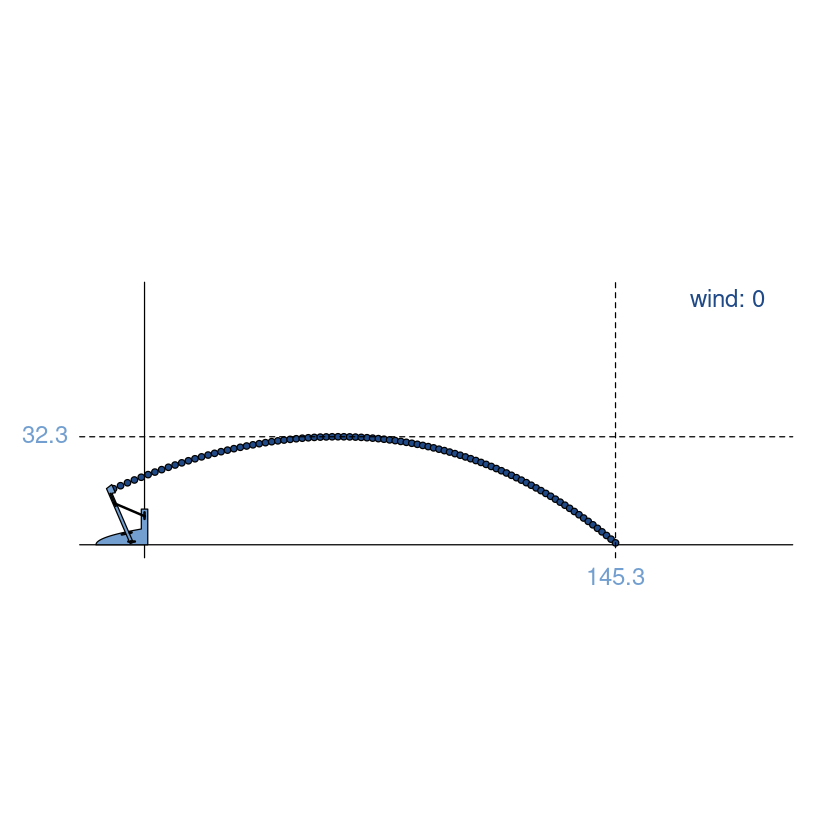

Expected improvement was: 18.45 
Actual improvement is: 21.3 
   (>0 means the new point is better, <0 means it is worse)

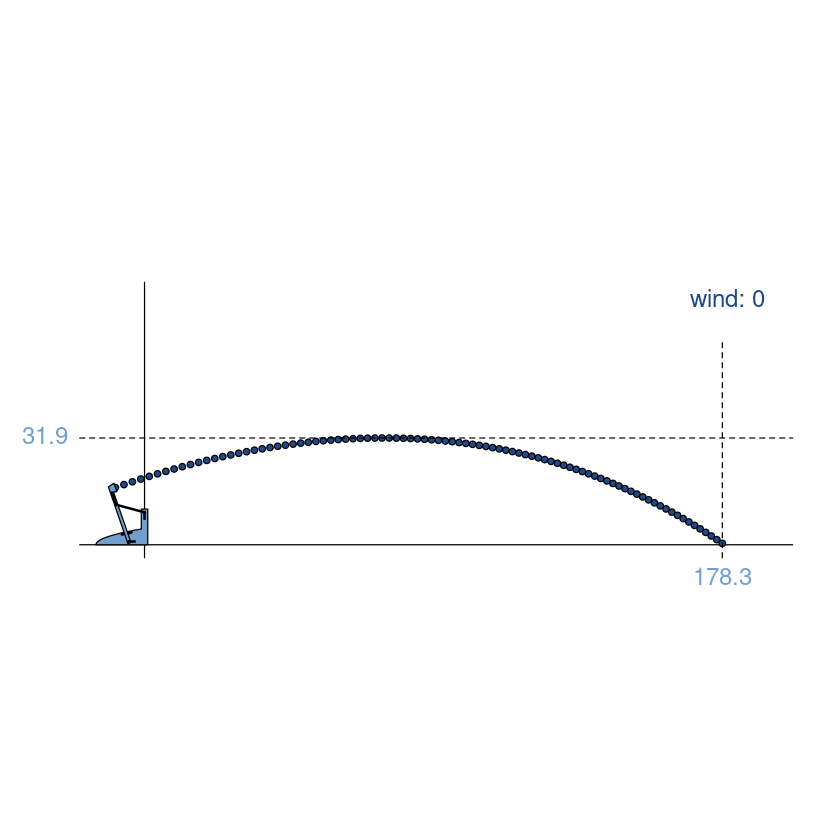

In [13]:
library(DiceOptim)

## We first transform the problem to a minimization one
runExperimentFun <- function(x) {
    - runExperiment(x, wind = 0)[1]
}
Y <- apply(X, 1, runExperimentFun)
mGP0 <- km(~ 1, design = X, response = Y)

## Step 1 ##
oEGO <- max_EI(model = mGP0, lower = rep(0, d), upper = rep(1, d))
newX <- oEGO$par
newy <- runExperimentFun(newX)

cat("Expected improvement was:", round(oEGO$value, 2),
    "\nActual improvement is:", round(min(Y) - newy, 2),
    "\n   (>0 means the new point is better, <0 means it is worse)")


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -78.94679 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       78.947  |proj g|=        1.513
At iterate     1  f =       76.714  |proj g|=        1.2541
At iterate     2  f =       76.106  |proj g|=        1.2439
At iterate     3  f =       74.572  |proj g|=       0.68364
At iterate     4  f =       74.408  |proj g|=        1.2066
At iterate     5  f =       74.358  |proj g|=       0.20531
At iterate     6  f =       74.356  |proj g|=      0.021574
At iterate     7  f =       74.356  |proj g|=    0.00098974
At iterate     8  f =       74.356  |proj g|=    2.

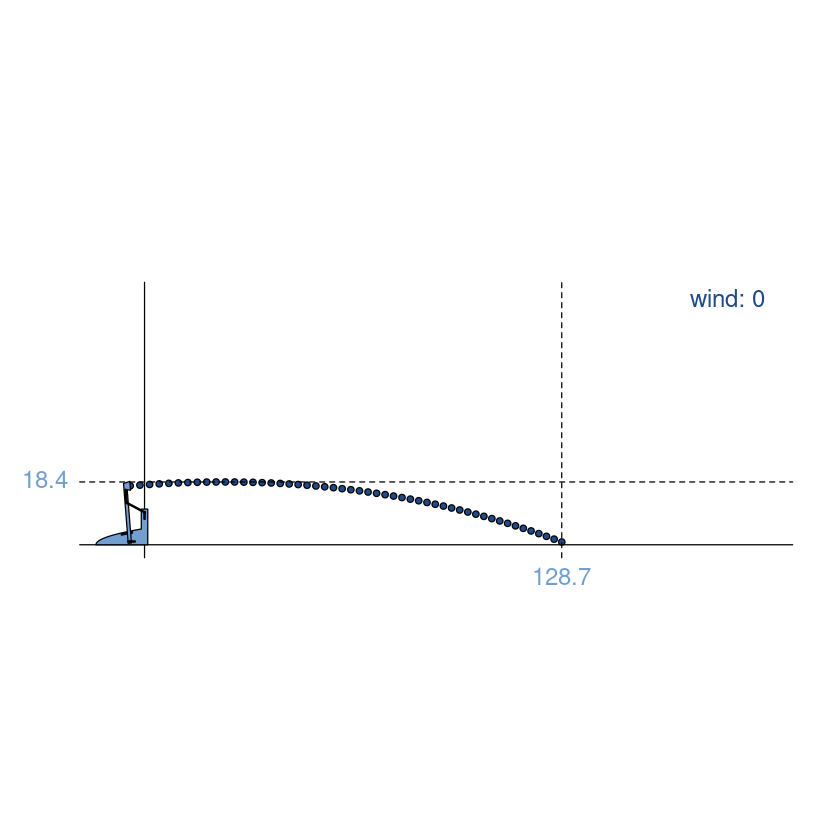

In [14]:
# Then we update the model
mGP1 <- update(mGP0, newX, newy)
# and maximize again the expected improvement: 
## Step 2 ##
oEGO <- max_EI(model = mGP1, lower = rep(0, d), upper = rep(1, d))
newX <- oEGO$par
newy <- runExperimentFun(newX)

cat("Expected improvement was:", round(oEGO$value, 2),
    "\nActual improvement is:", round(min(mGP1@y) - newy, 2),
    "\n   (>0 means the new point is better, <0 means its worst)")



Fri Sep 22 15:00:16 2023
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+00 
 0.000000e+00   <=  X2   <=    1.000000e+00 
 0.000000e+00   <=  X3   <=    1.000000e+00 
 0.000000e+00   <=  X4   <=    1.000000e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	5
	(2) Uniform Mutation.................. 	6
	(3) Boundary Mutation................. 	6
	(4) Non-Uniform Mutation.............. 	6
	(5) Polytope Crossover................ 	6
	(6) Simple Crossover.................. 	6
	(7) Whole Non-Uniform Mutation........ 	6
	(8) Heuristic Crossover............... 	6
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 12
Maximum Nonchanging Generations: 2
Population size       : 48
Convergence Tolerance: 1.000000e-21

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.


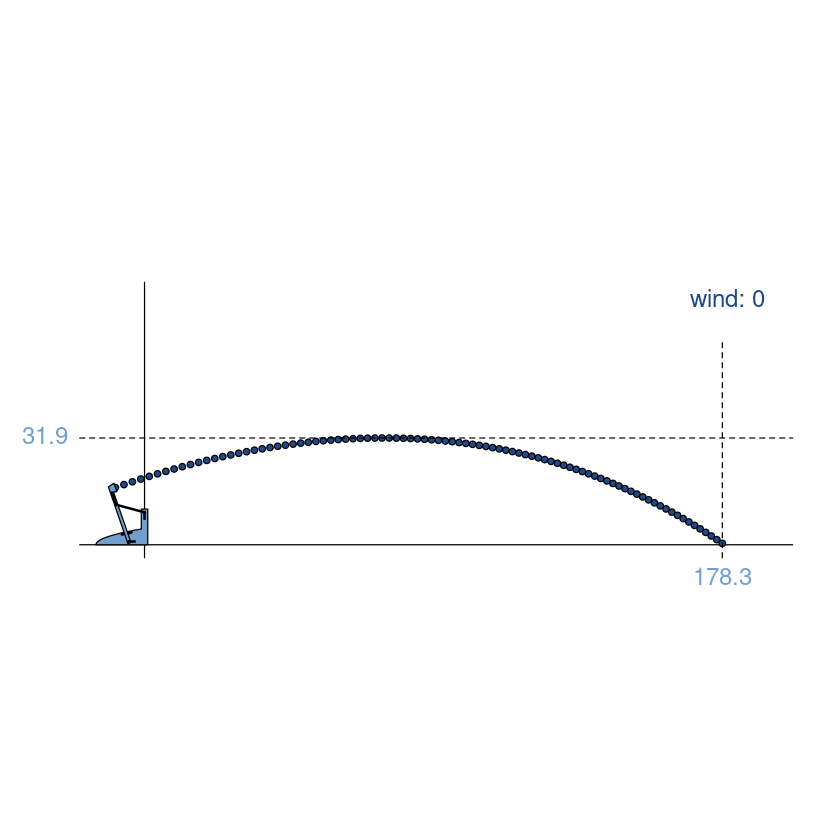


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -82.68546 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       82.685  |proj g|=       1.4785
At iterate     1  f =       81.613  |proj g|=        1.4899
At iterate     2  f =        81.23  |proj g|=       0.65956
At iterate     3  f =       81.128  |proj g|=       0.71906
At iterate     4  f =       80.822  |proj g|=        1.4286
At iterate     5  f =       80.781  |proj g|=       0.56703
At iterate     6  f =       80.721  |proj g|=       0.47208
At iterate     7  f =       80.682  |proj g|=       0.48031
At iterate     8  f =       80.635  |proj g|=      

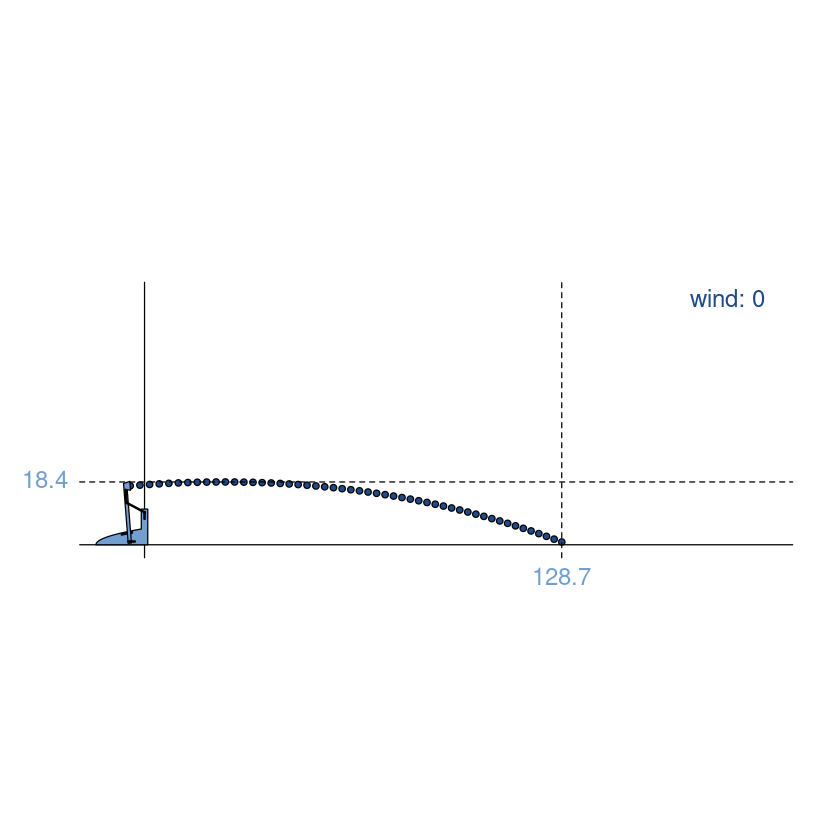


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -89.86481 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       89.865  |proj g|=       1.6428
At iterate     1  f =       83.675  |proj g|=         1.286
At iterate     2  f =       83.386  |proj g|=        1.4632
At iterate     3  f =       83.161  |proj g|=       0.30595
At iterate     4  f =       83.052  |proj g|=       0.19707
At iterate     5  f =       83.048  |proj g|=       0.18297
At iterate     6  f =       83.038  |proj g|=       0.41748
At iterate     7  f =       83.035  |proj g|=       0.34076
At iterate     8  f =       83.034  |proj g|=      

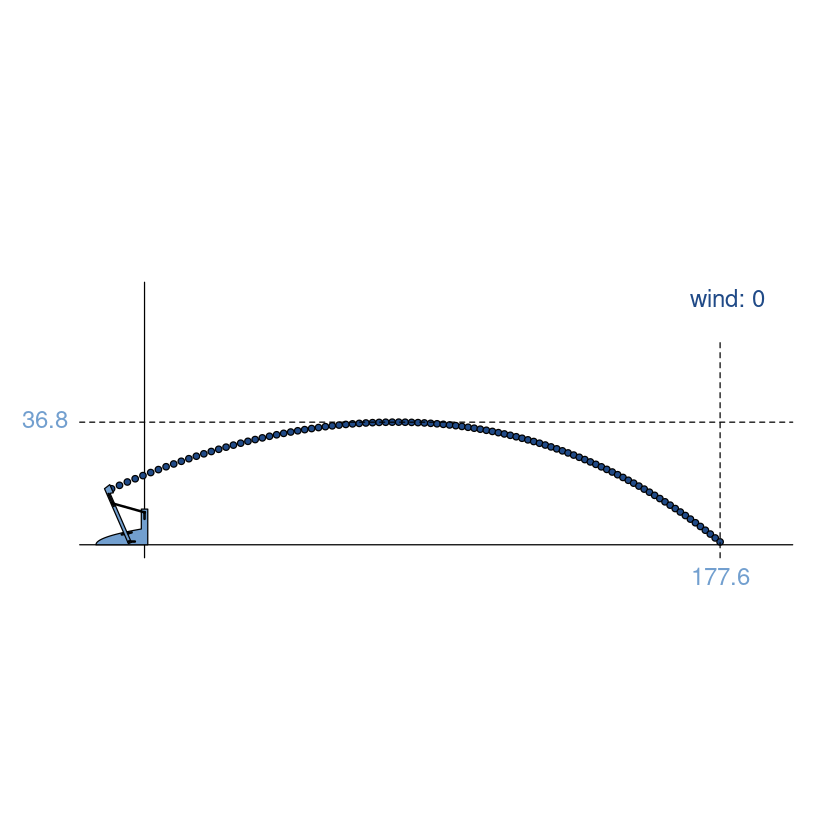


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -87.58017 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        87.58  |proj g|=       1.4679
At iterate     1  f =       87.414  |proj g|=       0.62276
At iterate     2  f =       86.443  |proj g|=       0.59714
At iterate     3  f =       86.134  |proj g|=        1.4243
At iterate     4  f =       85.779  |proj g|=        1.4314
At iterate     5  f =        85.17  |proj g|=       0.13032
At iterate     6  f =        85.17  |proj g|=       0.12923
At iterate     7  f =       85.169  |proj g|=       0.11836
At iterate     8  f =       85.168  |proj g|=      

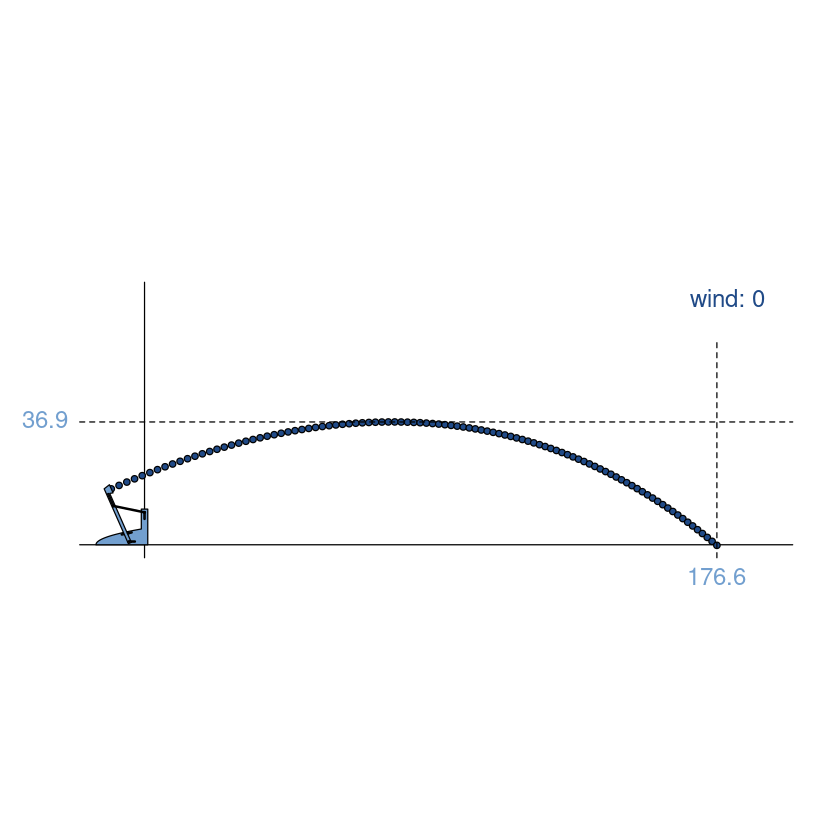


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -91.65901 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       91.659  |proj g|=        1.021
At iterate     1  f =       90.806  |proj g|=        0.8288
At iterate     2  f =       89.299  |proj g|=        1.4477
At iterate     3  f =       88.815  |proj g|=         1.408
At iterate     4  f =       87.655  |proj g|=       0.65129
At iterate     5  f =       87.619  |proj g|=       0.50952
At iterate     6  f =       87.609  |proj g|=       0.40236
At iterate     7  f =       87.606  |proj g|=        0.3965
At iterate     8  f =       87.586  |proj g|=      

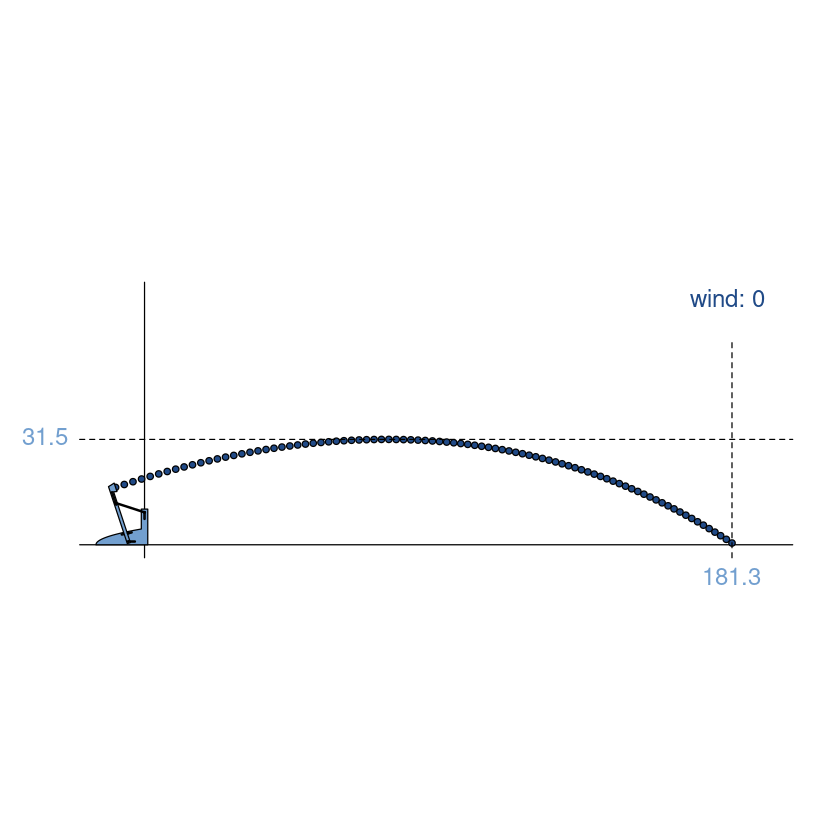


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -101.2685 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       101.27  |proj g|=       1.6017
At iterate     1  f =       97.119  |proj g|=        1.2812
At iterate     2  f =       93.651  |proj g|=        1.1985
At iterate     3  f =       92.604  |proj g|=        1.4612
At iterate     4  f =       92.185  |proj g|=       0.87772
At iterate     5  f =       92.059  |proj g|=       0.81811
At iterate     6  f =       91.817  |proj g|=       0.53151
At iterate     7  f =       91.789  |proj g|=       0.45736
At iterate     8  f =       91.781  |proj g|=      

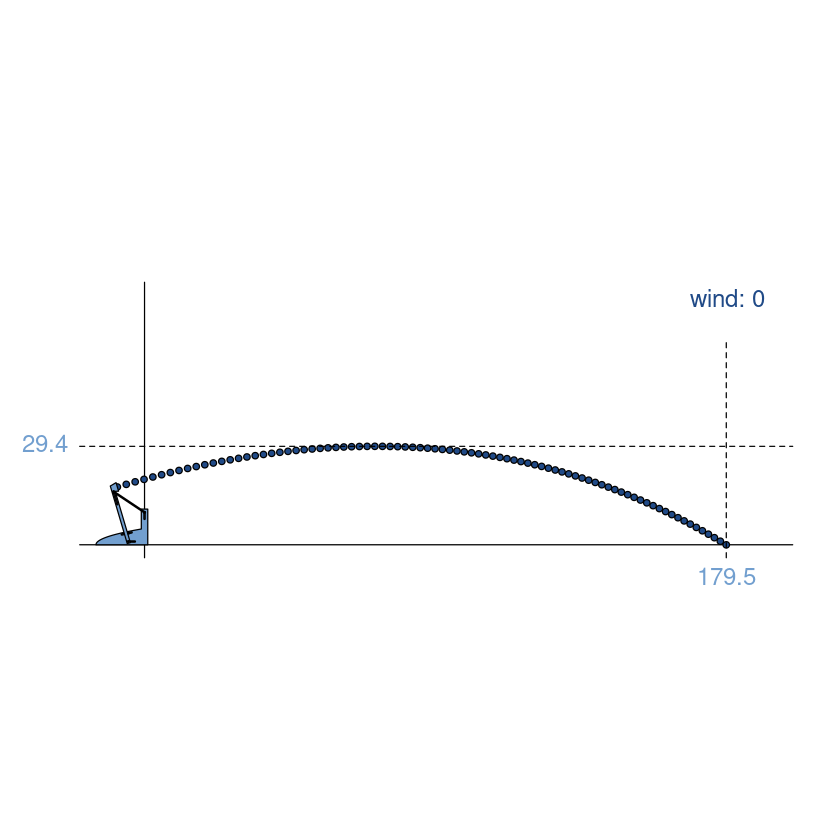


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -98.85726 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       98.857  |proj g|=       1.6105
At iterate     1  f =       96.093  |proj g|=        1.3156
At iterate     2  f =       95.542  |proj g|=        1.2602
At iterate     3  f =       95.155  |proj g|=       0.98434
At iterate     4  f =        94.95  |proj g|=        1.2233
At iterate     5  f =       94.679  |proj g|=        1.1869
At iterate     6  f =       94.668  |proj g|=       0.56937
At iterate     7  f =       94.627  |proj g|=       0.22591
At iterate     8  f =       94.624  |proj g|=      

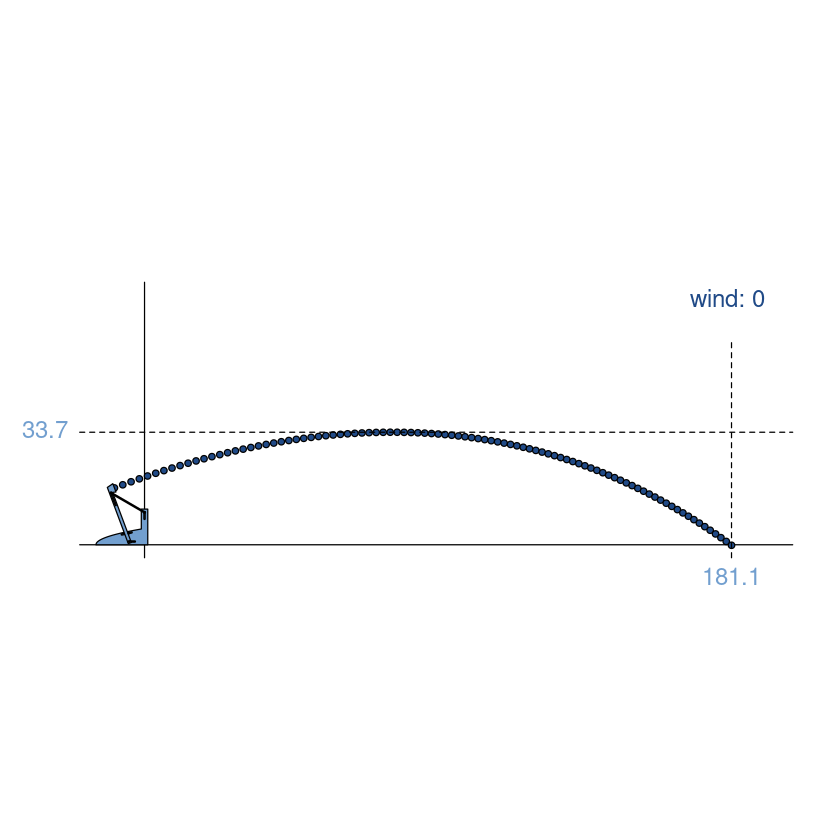


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -98.62605 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       98.626  |proj g|=        1.361
At iterate     1  f =       97.821  |proj g|=        1.2698
At iterate     2  f =       97.117  |proj g|=       0.77839
At iterate     3  f =       96.476  |proj g|=       0.79977
At iterate     4  f =       96.438  |proj g|=        0.7682
At iterate     5  f =       96.427  |proj g|=       0.41834
At iterate     6  f =       96.426  |proj g|=      0.066708
At iterate     7  f =       96.426  |proj g|=      0.065461
At iterate     8  f =       96.425  |proj g|=      

Warning message in genoud(EI, nvars = d, max = TRUE, pop.size = control$pop.size, :
“Stopped because hard maximum generation limit was hit.”


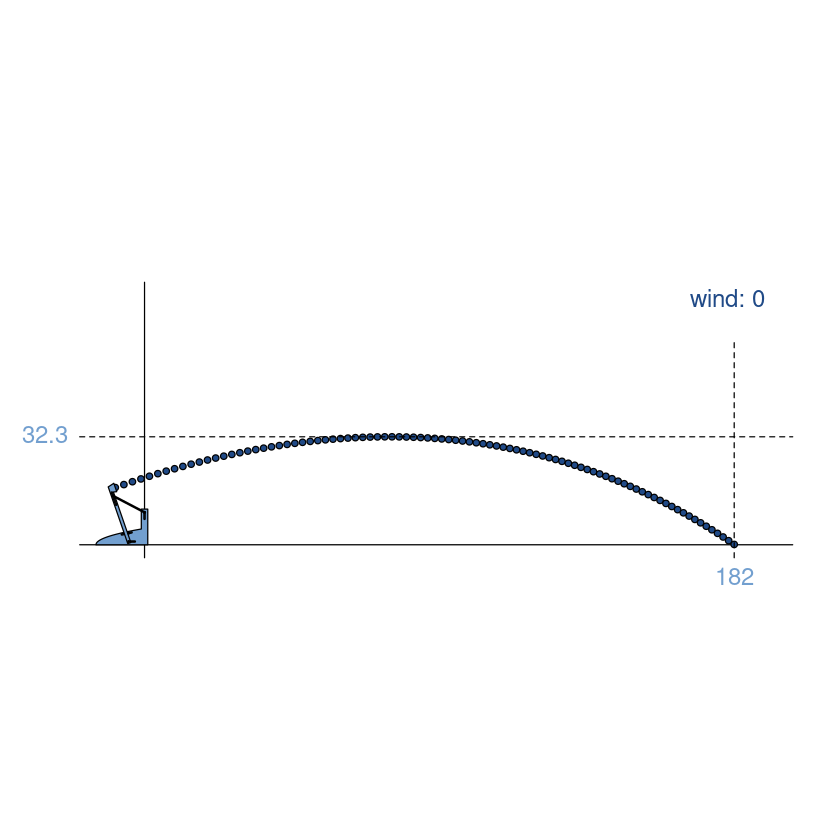


NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 9.610913e-02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	0.000000e+00	G[ 1] :	-2.846364e+00
 X[ 2] :	6.325678e-01	G[ 2] :	3.240315e-10
 X[ 3] :	1.000000e+00	G[ 3] :	7.120344e-01
 X[ 4] :	1.000000e+00	G[ 4] :	4.794444e+00

Solution Found Generation 12
Number of Generations Run 12

Fri Sep 22 15:00:22 2023
Total run time : 0 hours 0 minutes and 1 seconds


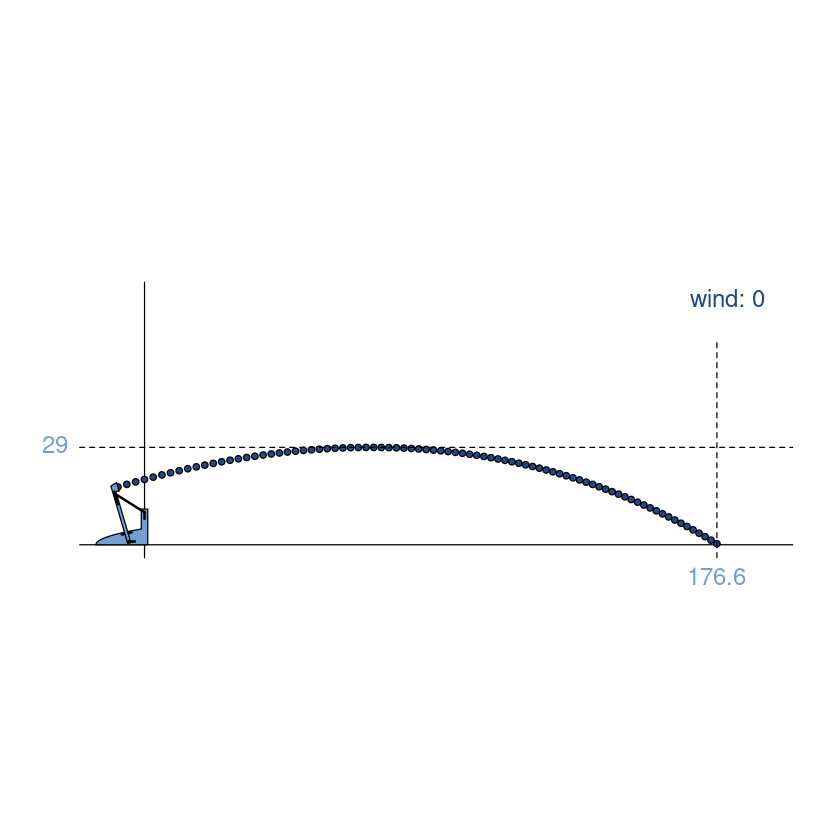


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -110.6083 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       110.61  |proj g|=       1.5276
At iterate     1  f =        108.3  |proj g|=        1.1127
At iterate     2  f =       104.92  |proj g|=        0.8896
At iterate     3  f =       103.41  |proj g|=       0.73518
At iterate     4  f =       103.22  |proj g|=        1.3308
At iterate     5  f =       102.69  |proj g|=       0.41189
At iterate     6  f =       102.55  |proj g|=        0.2756
At iterate     7  f =       102.54  |proj g|=       0.40223
At iterate     8  f =       102.53  |proj g|=      

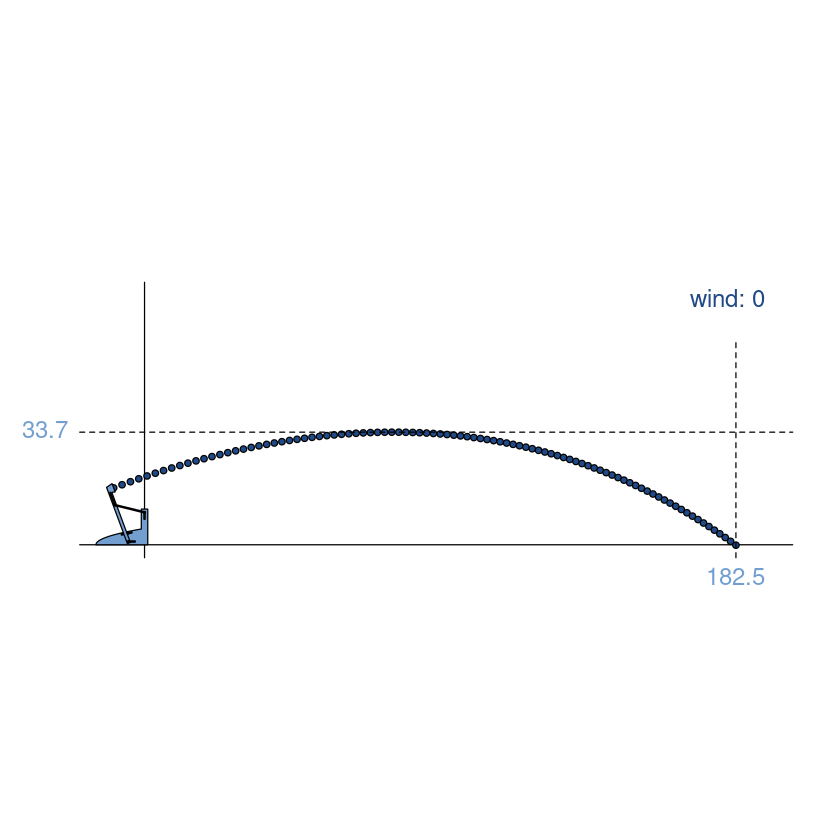


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -115.1057 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       115.11  |proj g|=       1.2525
At iterate     1  f =       106.05  |proj g|=        1.4831
At iterate     2  f =       105.62  |proj g|=       0.72728
At iterate     3  f =       104.92  |proj g|=        1.2571
At iterate     4  f =       104.83  |proj g|=       0.99852
At iterate     5  f =       104.78  |proj g|=       0.64028
At iterate     6  f =       104.67  |proj g|=         1.141
At iterate     7  f =       104.61  |proj g|=       0.74954
At iterate     8  f =        104.6  |proj g|=      

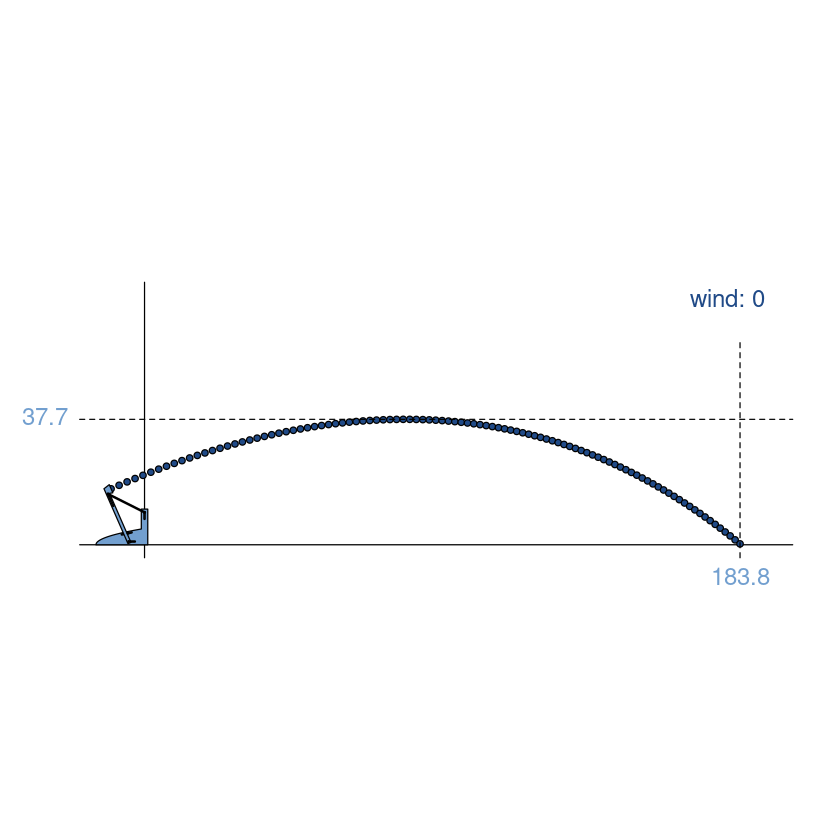


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -111.5132 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       111.51  |proj g|=      0.92124
At iterate     1  f =       111.25  |proj g|=       0.89153
At iterate     2  f =       110.17  |proj g|=        1.5092
At iterate     3  f =       109.89  |proj g|=        1.5037
At iterate     4  f =       109.66  |proj g|=        1.5051
At iterate     5  f =       109.35  |proj g|=       0.40256
At iterate     6  f =       109.31  |proj g|=       0.39993
At iterate     7  f =       109.31  |proj g|=      0.059925
At iterate     8  f =       109.31  |proj g|=     0

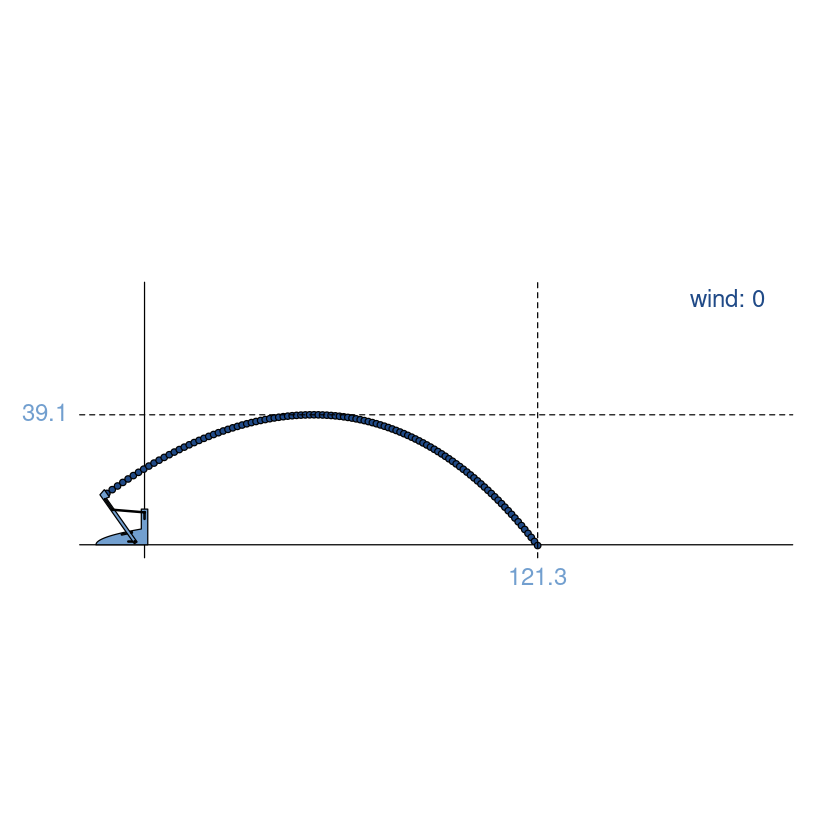


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -115.6972 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        115.7  |proj g|=        1.298
At iterate     1  f =       115.05  |proj g|=       0.61772
At iterate     2  f =        113.5  |proj g|=       0.42637
At iterate     3  f =       113.01  |proj g|=        1.5155
At iterate     4  f =        112.6  |proj g|=        1.5187
At iterate     5  f =       111.98  |proj g|=       0.66487
At iterate     6  f =       111.94  |proj g|=       0.37862
At iterate     7  f =       111.93  |proj g|=       0.22037
At iterate     8  f =       111.93  |proj g|=      

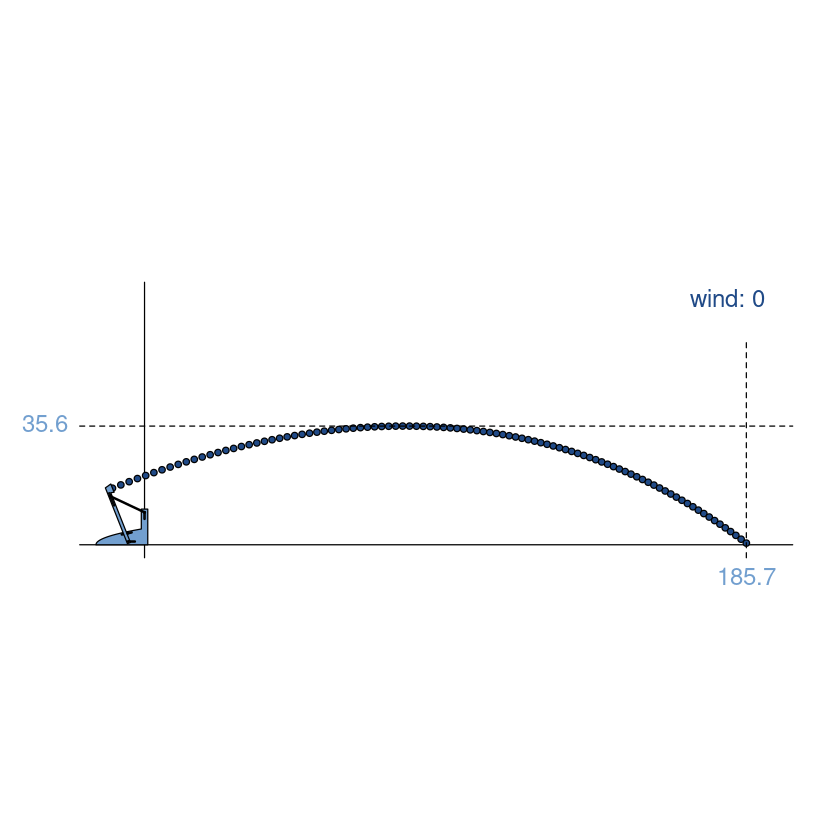


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -122.2567 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       122.26  |proj g|=       1.6538
At iterate     1  f =       118.83  |proj g|=       0.65239
At iterate     2  f =       118.05  |proj g|=       0.65838
At iterate     3  f =       117.01  |proj g|=       0.63501
At iterate     4  f =        116.5  |proj g|=        1.5778
At iterate     5  f =       115.86  |proj g|=        1.5373
At iterate     6  f =       115.21  |proj g|=        1.3448
At iterate     7  f =       115.19  |proj g|=       0.97379
At iterate     8  f =       115.17  |proj g|=      

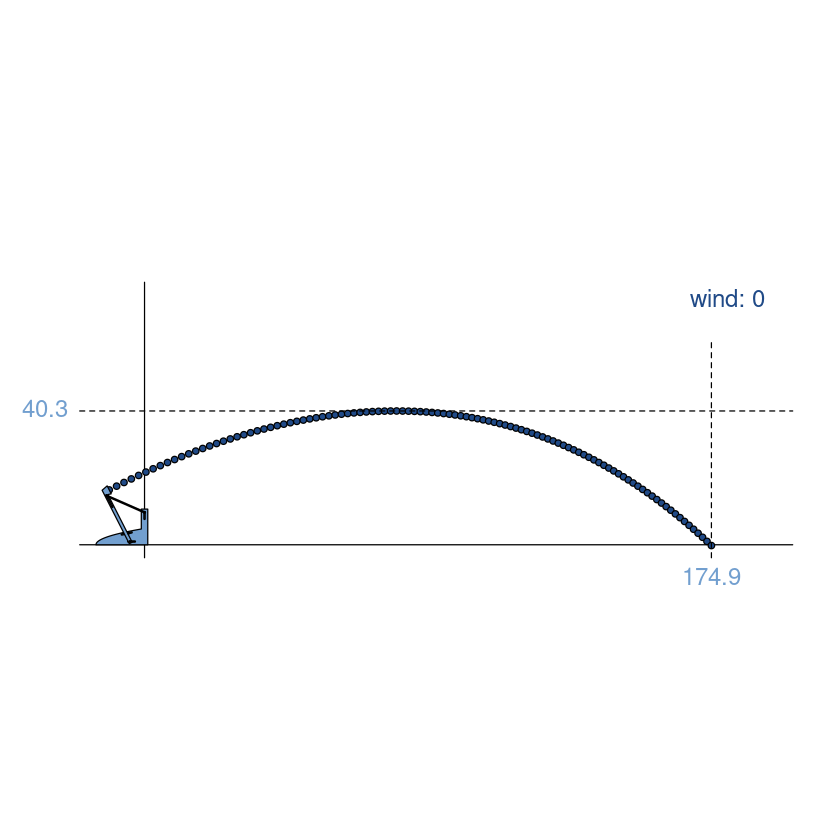


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -126.526 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       126.53  |proj g|=      0.96361
At iterate     1  f =       124.67  |proj g|=       0.88885
At iterate     2  f =       121.34  |proj g|=        1.5368
At iterate     3  f =       119.45  |proj g|=       0.66139
At iterate     4  f =       118.24  |proj g|=       0.62416
At iterate     5  f =       116.94  |proj g|=        1.5215
At iterate     6  f =       116.91  |proj g|=       0.88021
At iterate     7  f =       116.87  |proj g|=       0.35589
At iterate     8  f =       116.87  |proj g|=       

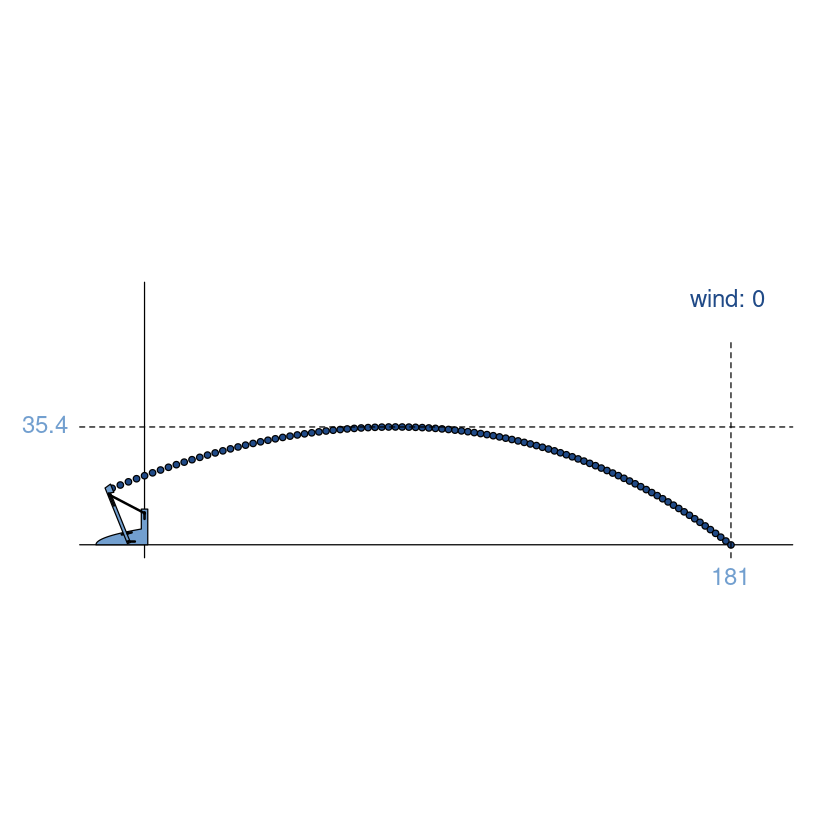


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -132.1551 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       132.16  |proj g|=        1.247
At iterate     1  f =       122.65  |proj g|=         1.637
At iterate     2  f =       120.69  |proj g|=        1.3744
At iterate     3  f =       119.99  |proj g|=        1.4058
At iterate     4  f =       119.03  |proj g|=        1.5321
At iterate     5  f =       118.27  |proj g|=        1.5571
At iterate     6  f =       117.95  |proj g|=        1.5321
At iterate     7  f =       117.92  |proj g|=       0.23496
At iterate     8  f =        117.9  |proj g|=      

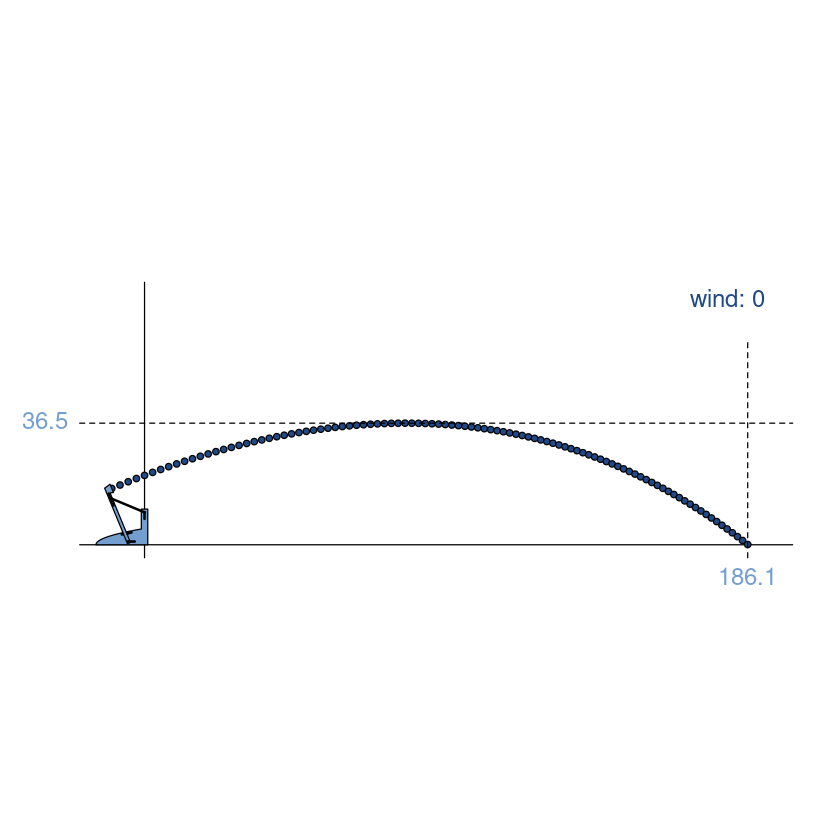


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -130.38 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       130.38  |proj g|=      0.66291
At iterate     1  f =       127.14  |proj g|=        1.5518
At iterate     2  f =       124.73  |proj g|=        1.3491
At iterate     3  f =       123.98  |proj g|=         1.326
At iterate     4  f =       123.19  |proj g|=        1.5586
At iterate     5  f =       122.99  |proj g|=        1.5322
At iterate     6  f =       122.95  |proj g|=       0.97593
At iterate     7  f =       122.94  |proj g|=       0.21511
At iterate     8  f =       122.91  |proj g|=       0

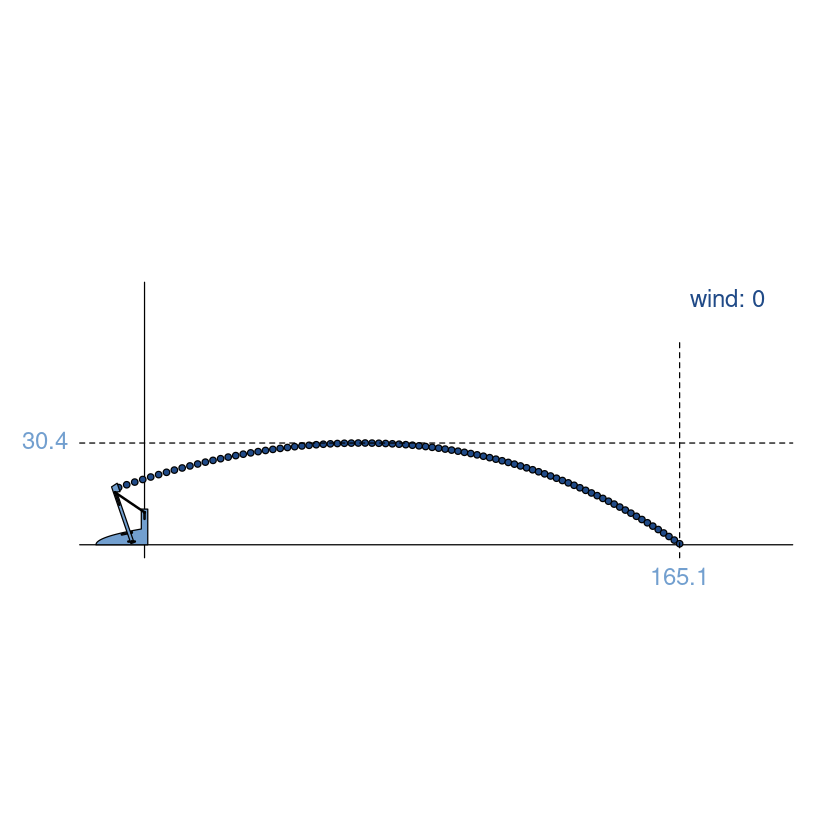


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -135.9937 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       135.99  |proj g|=       1.4784
At iterate     1  f =       132.21  |proj g|=        1.2602
At iterate     2  f =       129.05  |proj g|=        1.5617
At iterate     3  f =       128.21  |proj g|=       0.65706
At iterate     4  f =       127.71  |proj g|=       0.66517
At iterate     5  f =       126.01  |proj g|=        1.5549
At iterate     6  f =       125.68  |proj g|=        1.3348
At iterate     7  f =       125.67  |proj g|=       0.49178
At iterate     8  f =       125.66  |proj g|=      

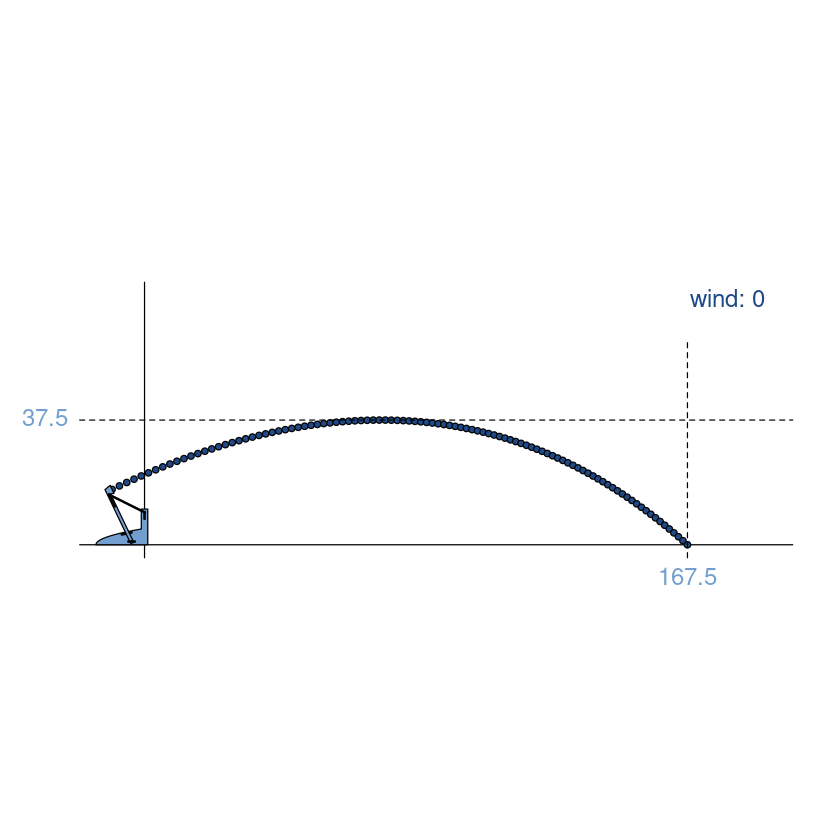


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -136.2374 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       136.24  |proj g|=      0.88447
At iterate     1  f =       130.44  |proj g|=       0.63615
At iterate     2  f =       128.87  |proj g|=        1.5222
At iterate     3  f =       127.37  |proj g|=        1.3482
At iterate     4  f =       127.33  |proj g|=       0.62386
At iterate     5  f =        127.3  |proj g|=       0.28078
At iterate     6  f =       127.28  |proj g|=       0.69741
At iterate     7  f =       127.23  |proj g|=        1.3545
At iterate     8  f =       127.16  |proj g|=      

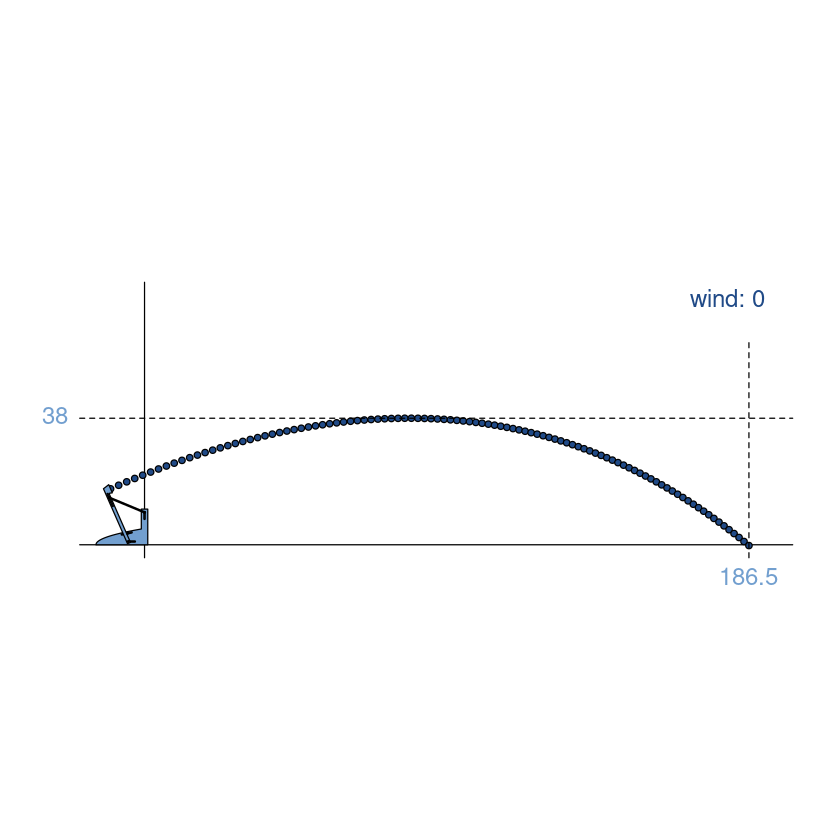


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  1.913159 1.86419 1.782744 1.887926 
  - best initial criterion value(s) :  -133.6458 

N = 4, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       133.65  |proj g|=      0.44361
At iterate     1  f =       132.78  |proj g|=        1.5087
At iterate     2  f =       132.23  |proj g|=        1.5335
At iterate     3  f =       130.95  |proj g|=        1.5273
At iterate     4  f =       130.93  |proj g|=       0.10925
At iterate     5  f =       130.93  |proj g|=      0.048196
At iterate     6  f =       130.93  |proj g|=       0.35401
At iterate     7  f =       130.92  |proj g|=       0.35577
At iterate     8  f =       130.92  |proj g|=      

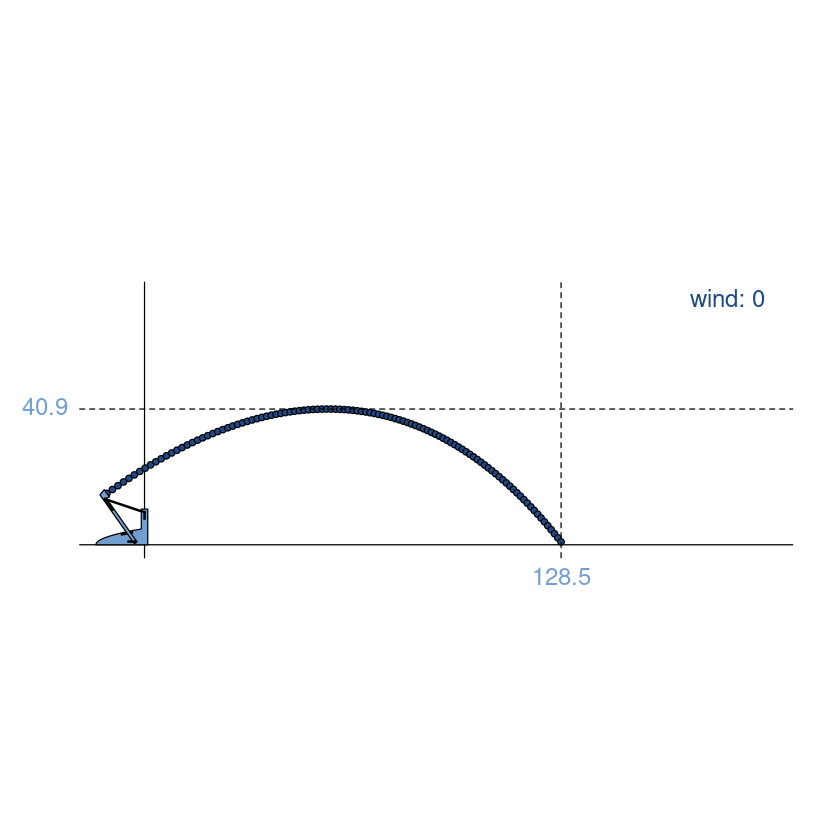

In [15]:
# Do a loop to automatize the process (for noise-free observations, you can also use EGO.nsteps)
nsteps <- 20
mGP <- mGP0
EGOpar <- matrix(NA, nrow = nsteps, ncol = d)
EGOvalue <- rep(NA, nsteps)
for (i in 1:nsteps){
    oEGO <- max_EI(model = mGP, lower = rep(0, d), upper = rep(1, d))
    newX <- EGOpar[i, ] <- oEGO$par
    newy <- EGOvalue[i] <- runExperimentFun(newX)
    mGP <- update(mGP, newX, newy)
}

bestIndex <- which.min(EGOvalue)
cat("longest shot observed:", - round(EGOvalue[bestIndex], 2),
    "\ncorresponding input values:", round(EGOpar[bestIndex, ], 2))


Global minimum found by EGO:

[1] 0.0000000 0.5857870 0.3021769 1.0000000

[1] -186.4981

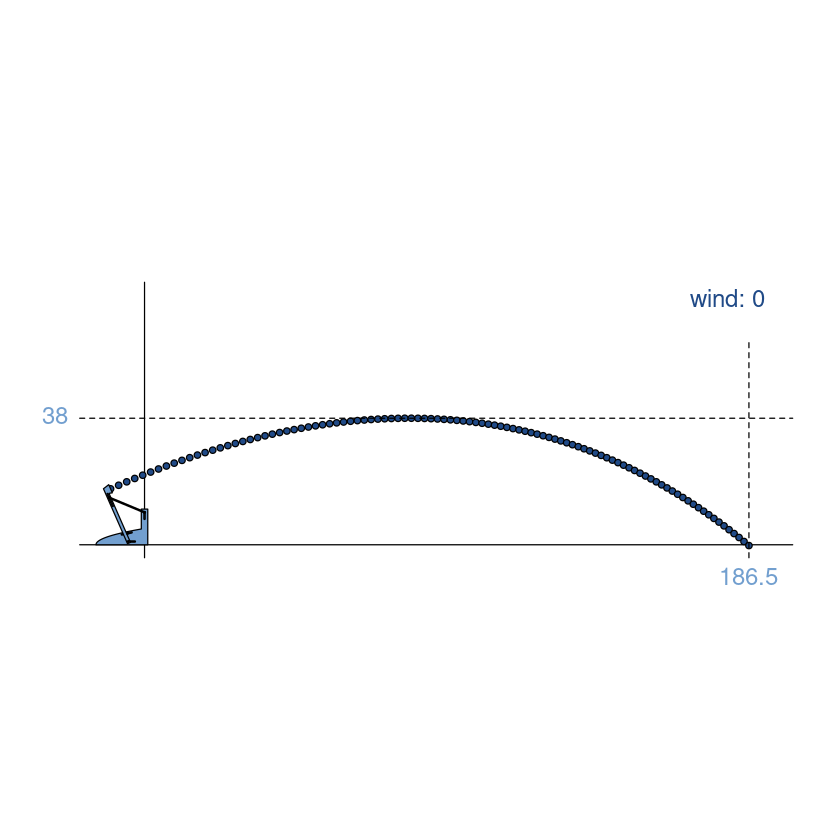

In [16]:
EGOpar[bestIndex, ]
runExperimentFun(EGOpar[bestIndex, ])

Let us visualize the 20 points computed with EGO in the X-Y space, and in time order.

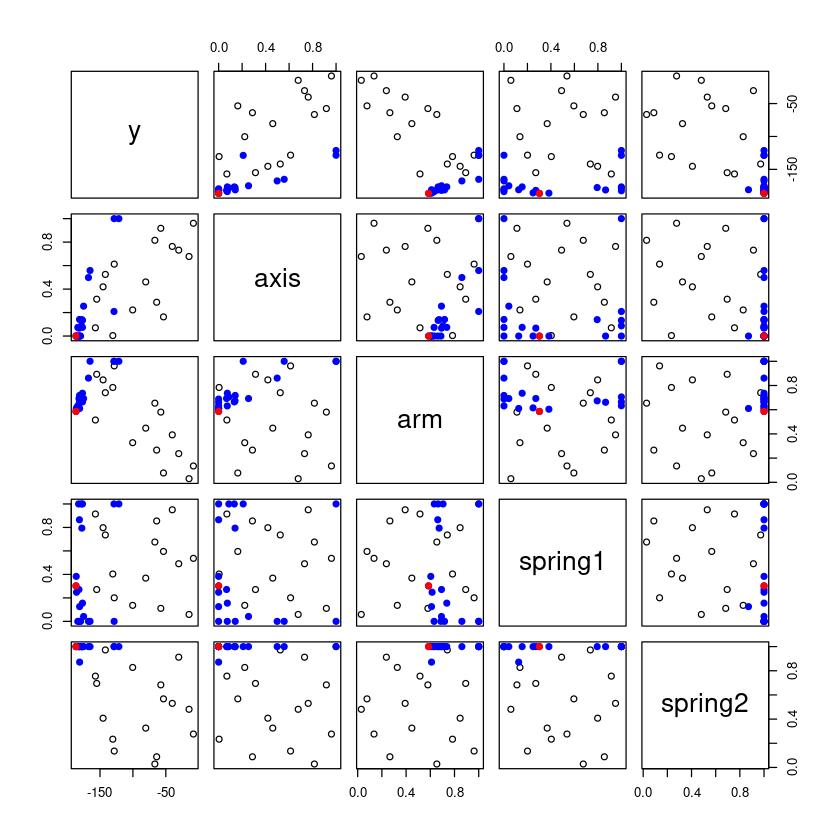

In [17]:
visualizeEGO <- function(initDesign, initValues, EGOpoints, EGOvalues){
  bestIndex <- which.min(EGOvalues)
  y <- c(initValues, EGOvalues, EGOvalues[bestIndex])
  X <- rbind(initDesign, EGOpoints, EGOpoints[bestIndex, ])
  nsteps <- nrow(EGOpoints)
  pairs(cbind(y, X), 
        col = c(rep("black", ninit), rep("blue", nsteps), "red"),
        pch = c(rep(1, ninit), rep(19, nsteps + 1)))
}

visualizeEGO(initDesign = X, initValues = Y,
             EGOpoints = EGOpar, EGOvalues = EGOvalue)

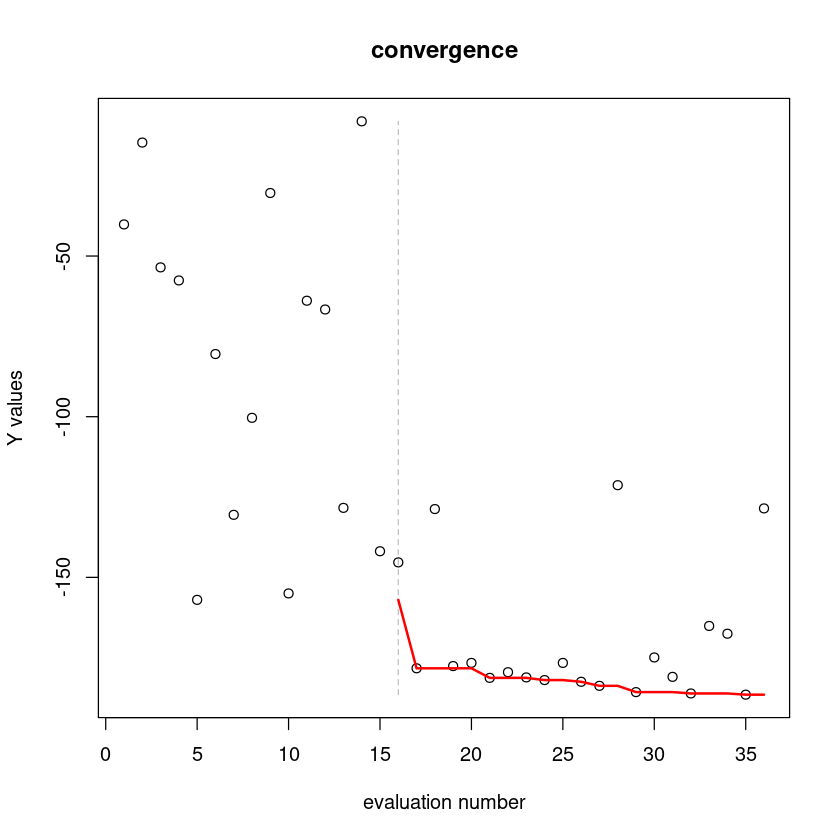

In [18]:
plot(c(Y, EGOvalue), main = "convergence", xlab = "evaluation number", ylab = "Y values")
lines(rep(ninit, 2), range(Y, EGOvalue), lty = 2, col = "gray")
lines(ninit + 0:nsteps, cummin(c(min(Y), EGOvalue)), col = "red", lwd = 2)

 Questions : 
 * *Why the EGO method would be much less efficient by using a linear model instead of a GP model?*
 * *Modify the code in order to deal with noisy observations, with the EQI criterion (mind using the argument 'noise.var' in 'km').*
 * *Investigate the influence: [a] of a trend in the model (change 'formula' in 'km'); [b] of a kernel; [c] of the initial sample size.*
 * *Adapt the EGO method in order to provide a batch of 2 points at one (function qEGO.nsteps), which is useful in practice, as the 2 runs of the time-consuming simulator can be done in parallel.*

Bonus : As the function is quick to evaluate, compare the result with the maximum value obtained with a standard optimizor (from library nloptr for instance). You can use the 'runExperimentFun' function defined above.